In [59]:
from read_data import load_dataset, get_synth_data
import matplotlib.pyplot as plt
#from losses import *
import numpy as np
import pickle
from models.ensemble import Ensemble
from models.dropout import Dropout
from models.evidental import Evidental
from models.evidental_gauss import EvidentalGauss
import tensorflow_probability as tfp
tfd = tfp.distributions

In [60]:
from quantilelosses import quant_evi_loss

In [61]:
def get_hparams(dataset, model):
    # open pickle file
    with open('hparams/' + dataset + '/' + model + '.pickle', 'rb') as handle:
        hparams = pickle.load(handle)
    return hparams['params']


datasets = ['boston', 'concrete', 'energy-efficiency', 'kin8nm', 'naval', 'protein', 'power-plant', 'wine', 'yacht']
models = ['dropout', 'ensemble', 'evidental']

for d in datasets:
    print(d)
    for m in models:
        print(get_hparams(d, m))

boston
{'batch_size': 38.89677642078301, 'dropout': 0.3379980239956277, 'lr': 0.003323040933577446}
{'batch_size': 38.89677642078301, 'dropout': 0.3379980239956277, 'lr': 0.003323040933577446}
{'batch_size': 26.315753273848422, 'dropout': 0.27348046907181134, 'lr': 0.0021600051890149226}
concrete
{'batch_size': 65.05157557976597, 'dropout': 0.10146035146056623, 'lr': 0.0006574469213691146}
{'batch_size': 65.05157557976597, 'dropout': 0.10146035146056623, 'lr': 0.0006574469213691146}
{'batch_size': 65.16915397779051, 'dropout': 0.11879125140613285, 'lr': 0.0025373338951285873}
energy-efficiency
{'batch_size': 65.09088103254834, 'dropout': 0.14917951699720244, 'lr': 0.002003956779888646}
{'batch_size': 65.09088103254834, 'dropout': 0.14917951699720244, 'lr': 0.002003956779888646}
{'batch_size': 65.12009140411794, 'dropout': 0.12387115864382735, 'lr': 0.001996240834098853}
kin8nm
{'batch_size': 64.94270358417876, 'dropout': 0.11973980415755148, 'lr': 0.00012136419985799106}
{'batch_size':

In [62]:
(x_train, y_train), (x_test, y_test), y_train_mu, y_train_scale = load_dataset("concrete")

Loading dataset concrete....
Done loading dataset concrete


In [63]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    scale[scale<1e-10] = 1.0

    data = (data - mu) / scale
    return data, mu, scale

In [64]:
def get_dist(which, x):
    return {
        'Gaussian': tfd.Normal(0,3*abs(x)+0.2),
        'Expo': tfd.Exponential(rate=1/(4* abs(x)+0.2)),
        'Gamma': tfd.Gamma(3*abs(x), 1/(2*abs(x)+0.2)),
        'HalfCauchy': tfd.HalfCauchy(loc=0., scale=0.5*abs(x)+0.2),
        'Laplace': tfd.Laplace(loc=0., scale=5*abs(x)+0.2),
        'Dis': tfd.Exponential(rate=(abs(x)/4)),
    }[which]


def get_synth_data(name = 'Gaussian', x_min=-4, x_max=4, n=1000, quantiles = [0.5], train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    sigma = 3 * abs(x)+0.2 if train else np.zeros_like(x)
    dist = get_dist(name, x)
    y = x**3+dist.sample().numpy().astype(np.float32)    

    return x, y, x**3+dist.quantile(quantiles).numpy().astype(np.float32)

def get_plot_data(name = 'Expo', x_min=-4, x_max=4, n=1000, quantiles = [0.5], train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)
    
    sigma = 3 * abs(x)+0.2 if train else np.zeros_like(x)
    dist = get_dist(name, x)
    y = dist.sample().numpy().astype(np.float32)    

    return x, y, dist.quantile(quantiles).numpy().astype(np.float32)



In [65]:
#x_train, y_train, y_train_q95 = get_synth_data('Expo', x_min=-4,x_max= 4, n=1000, train=True, quantiles=[0.05, 0.95])
#x_test, y_test, y_test_q95 = get_synth_data('Expo', -4, 4, n=1000, train=True, quantiles=[0.05, 0.95])

#x_plot, y_plot,  y_plot_dist = get_synth_data('Expo', -7, 7, n=100, train=True, quantiles=[0.05, 0.95])

x_train, y_train, y_train_q95 = get_plot_data('Expo', x_min=-4,x_max= 4, n=1000, train=True, quantiles=[0.05, 0.95])
x_test, y_test, y_test_q95 = get_plot_data('Expo', -4, 4, n=1000, train=True, quantiles=[0.05, 0.95])

x_plot, y_plot,  y_plot_dist = get_plot_data('Expo', -7, 7, n=100, train=True, quantiles=[0.05, 0.95])


x_train, x_train_mu, x_train_scale = standardize(x_train)
x_test = (x_test - x_train_mu) / x_train_scale

x_plot = (x_plot - x_train_mu) / x_train_scale

y_train, y_train_mu, y_train_scale = standardize(y_train)
y_test = (y_test - y_train_mu) / y_train_scale
y_plot = (y_plot - y_train_mu) / y_train_scale


In [120]:
Evi = Evidental(input_shape=x_train.shape[1:], 
            num_neurons= 32, 
            num_layers=2, 
            lam=0.0,
            activation='relu',
            drop_prob=0.0,
            coeff=5e-1,
            learning_rate=3e-3,
            patience=250)

eve_g = EvidentalGauss(input_shape=x_train.shape[1:], 
            num_neurons= 32, 
            num_layers=2, 
            lam=0.0,
            activation='relu',
            drop_prob=0.0,
            learning_rate=3e-3,
            patience=50)

#hpara = get_hparams("boston", "dropout")
Drop = Dropout(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)

#hpara = get_hparams("boston", "ensemble")
Ense = Ensemble(input_shape=x_train.shape[1:], 
            num_neurons= 128, 
            num_layers=3, 
            lam=0.0,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=3e-3,
            patience=250)


print(Evi.drop_prob)
print(Drop.drop_prob)
print(Ense.drop_prob)


0.0
0.1
0.1


In [121]:
eve_g.train(x_train, y_train, batch_size=128, epochs=1000)
#Drop.train(x_train, y_train, batch_size=128, epochs=1000)
#Ense.train(x_train, y_train, batch_size=128, epochs=1000)
Evi.train(x_train, y_train, batch_size=128, epochs=1000)

Epoch 1/1000


8/8 [==============================] - 1s 21ms/step - loss: 1.3531 - val_loss: 1.7586
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.2941 - val_loss: 1.8895
Epoch 3/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.2555 - val_loss: 1.9958
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.2309 - val_loss: 2.0736
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.1979 - val_loss: 2.1364
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.1501 - val_loss: 2.0116
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.1059 - val_loss: 1.8832
Epoch 8/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.0628 - val_loss: 1.8264
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.0237 - val_loss: 1.7941
Epoch 10/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.9935 - val_loss: 1.7217
Epoch 11/1000
8/8 [============

In [122]:
print("Evidence: ", Evi.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_train, y_train, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_train, y_train, y_train_mu, y_train_scale))

print("Evidence: ", Evi.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Dropout: ", Drop.evaluate(x_test, y_test, y_train_mu, y_train_scale))
print("Ensemble: ", Ense.evaluate(x_test, y_test, y_train_mu, y_train_scale))

Evidence:  (1.5442595, 6.983738, 0.001510930061340332)
Dropout:  (6.834093, 10.936614, 0.04017859697341919)
Ensemble:  (6.950486, 10.951524, 0.01847982406616211)
Evidence:  (1.816561, 7.245499, 0.0015802264213562011)
Dropout:  (7.5489354, 11.052527, 0.039587342739105226)
Ensemble:  (7.6637626, 11.059643, 0.018891441822052)


In [123]:
#plt.plot(Evi.history.history['val_nll_eval'], c='red', linestyle='--')
#plt.plot(Evi.history.history['nll_eval'], c='red', label='Evidental')
#plt.plot(Drop.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(Drop.history.history['loss'], c='blue', label='Dropout')
#plt.plot(eve_g.history.history['val_loss'], c='blue', linestyle='--')
#plt.plot(eve_g.history.history['loss'], c='blue', label='Dropout')
#plt.plot(Ense.history[0].history['val_loss'], c='green', linestyle='--')
#plt.plot(Ense.history[0].hi
# story['loss'], c='green', label='Ensemble')
#plt.legend()
#plt.show()
#plt.plot(Evi.history.history['val_loss'], c='red', linestyle='--')
#plt.plot(Evi.history.history['loss'], c='red', label='Evidental')
#plt.show()

In [124]:
evi_preds = Evi.predict(x_test)
drop_preds = Drop.predict(x_test)
ense_preds = Ense.predict(x_test)

In [125]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
output = eve_g.model(x_test)
mu, v, alpha, beta = tf.split(output, 4, axis=-1)

In [126]:
dist = tfd.Normal(loc=(mu*y_train_scale) + y_train_mu, scale=y_train_scale*np.sqrt(beta/(v*(alpha-1))))

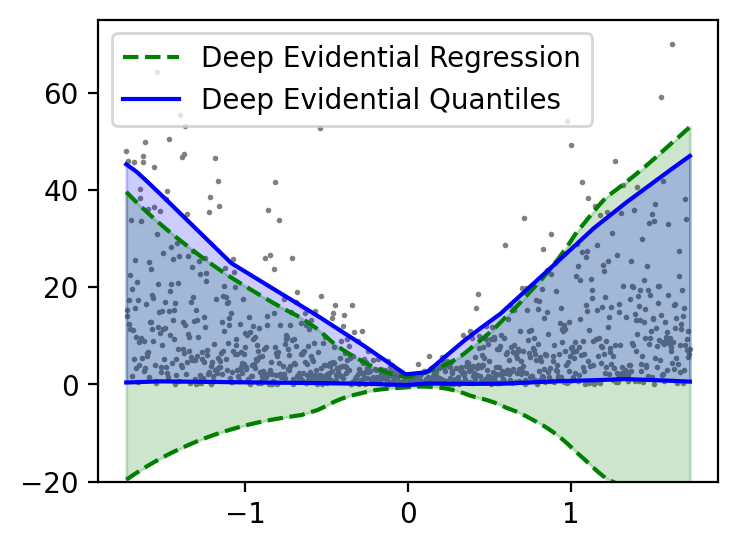

In [128]:
plt.figure(figsize=(4,3), dpi=200)

plt.scatter(x_test, y_test* y_train_scale + y_train_mu, s=1, c='gray')#, label='Data')
#plt.plot(x_test, mu)
#plt.plot(x_test, mu + 2*np.sqrt(beta/(v*(alpha-1))))
#plt.plot(x_test, mu - 2*np.sqrt(beta/(v*(alpha-1))))
#plt.plot(x_test, dist.mean(), c='green')
plt.plot(x_test, dist.quantile([0.95]), '--', c='green')
plt.plot(x_test, dist.quantile([0.05]), '--', c='green', label='Deep Evidential Regression')
#plt.plot(x_test, y_test_q95[:,0], c='red')
#plt.plot(x_test, y_test_q95[:,1], c='red')

plt.fill_between(x_test[:,0], dist.quantile([0.05])[:,0],
                        dist.quantile([0.95])[:,0], alpha=0.2, color='green')
#plt.plot(x_test, tf.expand_dims(drop_preds[:,1],1)* y_train_scale + y_train_mu, c='orange')
#plt.plot(x_test, tf.expand_dims(drop_preds[:,0],1)* y_train_scale + y_train_mu, c='orange')
#plt.plot(x_test, tf.expand_dims(ense_preds[:,1],1)* y_train_scale + y_train_mu, c='yellow')
#plt.plot(x_test, tf.expand_dims(ense_preds[:,0],1)* y_train_scale + y_train_mu, c='yellow')
plt.plot(x_test, tf.expand_dims(evi_preds[:,1],1)* y_train_scale + y_train_mu, c='blue')
plt.plot(x_test, tf.expand_dims(evi_preds[:,0],1)* y_train_scale + y_train_mu, c='blue', label='Deep Evidential Quantiles')

plt.fill_between(x_test[:,0], (tf.expand_dims(evi_preds[:,0],1)* y_train_scale + y_train_mu)[:,0], 
                        (tf.expand_dims(evi_preds[:,1],1)* y_train_scale + y_train_mu)[:,0], alpha=0.2, color='blue')
plt.legend(loc='upper left')
plt.ylim(-20, 75)
plt.savefig("fig_1d.pdf", bbox_inches='tight')

In [55]:
print("Evidence")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(evi_preds[:,i],1)).numpy().mean()))

print("Dropout")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(drop_preds[:,i],1)).numpy().mean()))

print("Ensemble")
for i, q in enumerate(Evi.quantiles):
    print("The q is {} model have {}".format(q, (y_test<tf.expand_dims(ense_preds[:,i],1)).numpy().mean()))


Evidence
The q is 0.05 model have 0.057
The q is 0.95 model have 0.951
Dropout
The q is 0.05 model have 0.675
The q is 0.95 model have 0.695
Ensemble
The q is 0.05 model have 0.674
The q is 0.95 model have 0.685


In [17]:
def plot_q(x_train, y_train, x_test, y_test, model):
    #mu, var_ = model.get_mu_sigma(x_test)
    mu = model.predict(x_test)
    var_ = model.get_uncertainties(x_test)
    mu = (mu*y_train_scale) + y_train_mu
    var_ = var_*y_train_scale
    y_test = (y_test*y_train_scale) + y_train_mu
    y_train = (y_train*y_train_scale) + y_train_mu
    x_train = (x_train*x_train_scale) + x_train_mu
    x_test = (x_test*x_train_scale) + x_train_mu
    for i, q in enumerate(model.quantiles):
        plot_predictions(x_train, y_train, x_test, y_test, mu[:,i], var=var_[:,i], quantile=q, n_stds=4, kk=i)

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, var, quantile, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    x_train = x_train[:, 0]
    #var = np.minimum(var, 1e3)  # for visualization
    plt.figure(figsize=(5, 3), dpi=200)
    plt.title("Quantile: {:.2f}".format(quantile))
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    #plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.scatter(x_test, y_test, c='r',s=1., zorder=2, label="True")
    plt.plot(x_test, y_pred, color='#007cab', zorder=3, label="Pred")
    #plt.plot(x_test, mu_z, color='green', zorder=3, label="Pred_or")
    #plt.plot(x_test, mu_z+2*std_z, color='green', linestyle='--', zorder=3, label="Pred_or")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

    for k in np.linspace(0, n_stds, 4):
        #print(var.shape)
        #print(mu.shape)
        #print((k*var).shape)
        plt.fill_between(
            x_test, (y_pred - k * var), (y_pred + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    #plt.gca().set_ylim(-5, 5)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


In [18]:
evi_preds = Evi.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Evi.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Evi.get_uncertainties(x_plot)*y_train_scale

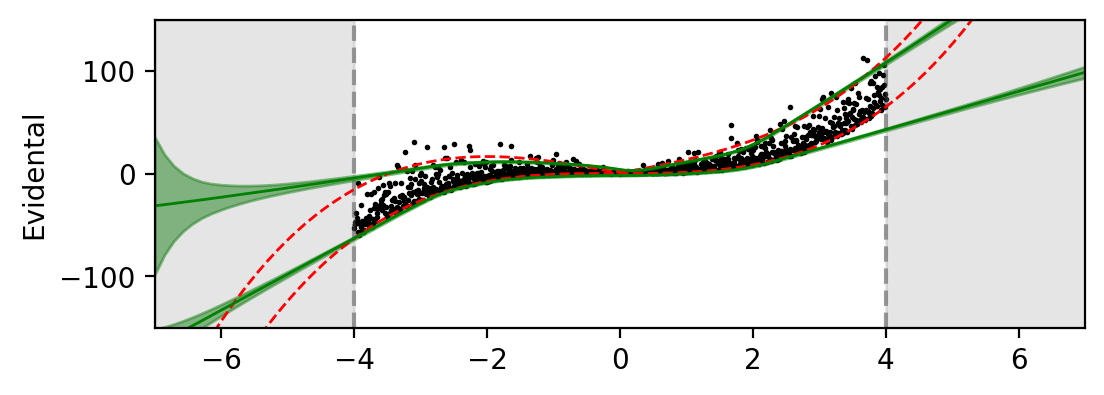

In [40]:
evi_preds = Evi.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Evi.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Evi.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='green', linewidth=1)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.3)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='green', linewidth=1)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.ylabel("Evidental")
plt.savefig('qualitiv_evi_ale.pdf', bbox_inches='tight')

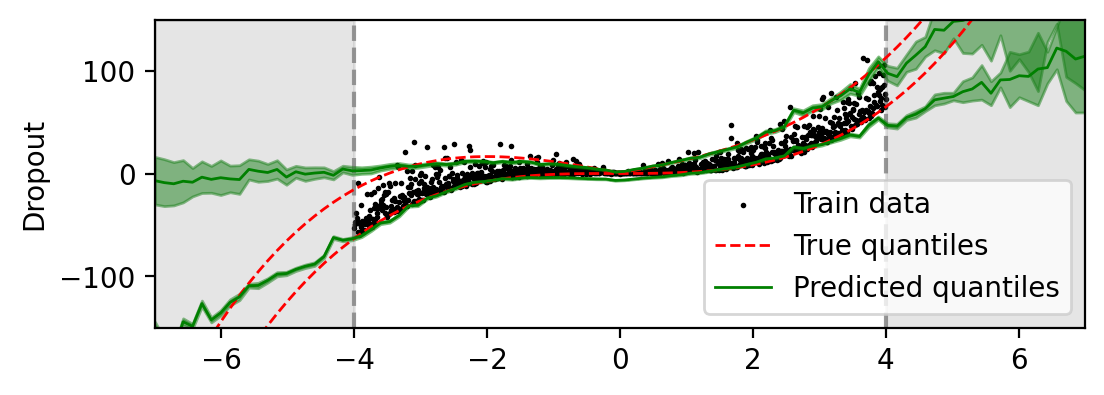

In [41]:
evi_preds = Drop.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Drop.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Drop.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black', label='Train data')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--', label='True quantiles')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='green', linewidth=1)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.3)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='green', linewidth=1, label='Predicted quantiles')
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.legend(loc='lower right')
plt.ylabel("Dropout")
plt.savefig('qualitiv_drop_ale.pdf', bbox_inches='tight')

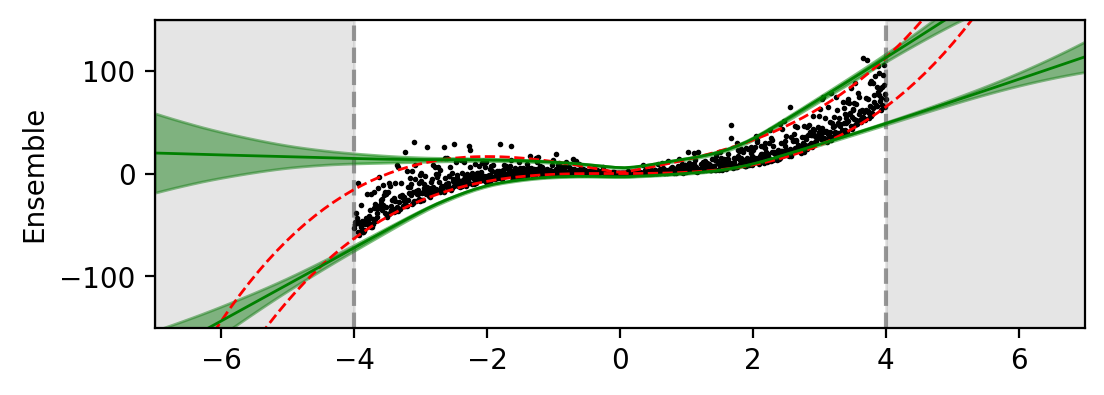

In [42]:
evi_preds = Ense.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Ense.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Ense.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='green', linewidth=1)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.3)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='green', linewidth=1)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.ylabel("Ensemble")
plt.savefig('qualitiv_ense_ale.pdf', bbox_inches='tight')

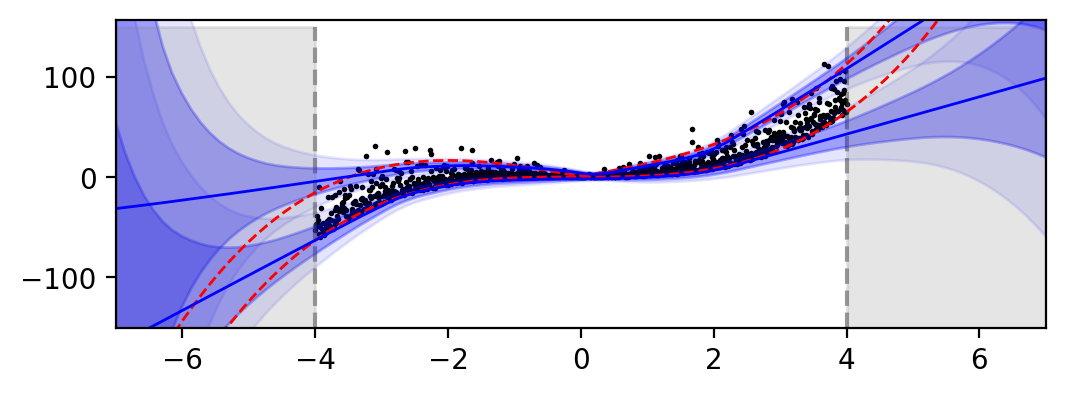

In [43]:
evi_preds = Evi.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Evi.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Evi.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='blue', linewidth=1)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.1)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='blue', linewidth=1)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 157)
plt.xlim(-7, 7)
plt.savefig('qualitiv_evi_epi.pdf', bbox_inches='tight')

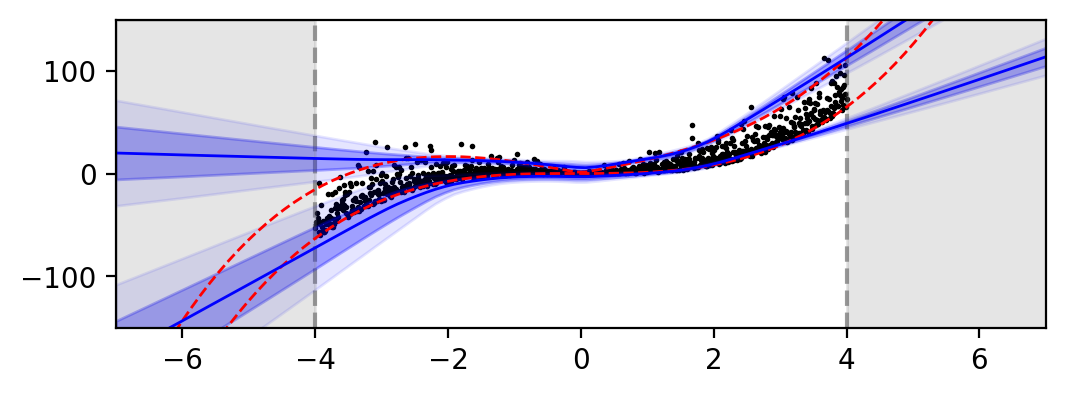

In [46]:
evi_preds = Ense.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Ense.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Ense.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='blue', linewidth=1)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.1)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='blue', linewidth=1)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.savefig('qualitiv_ense_epi.pdf', bbox_inches='tight')

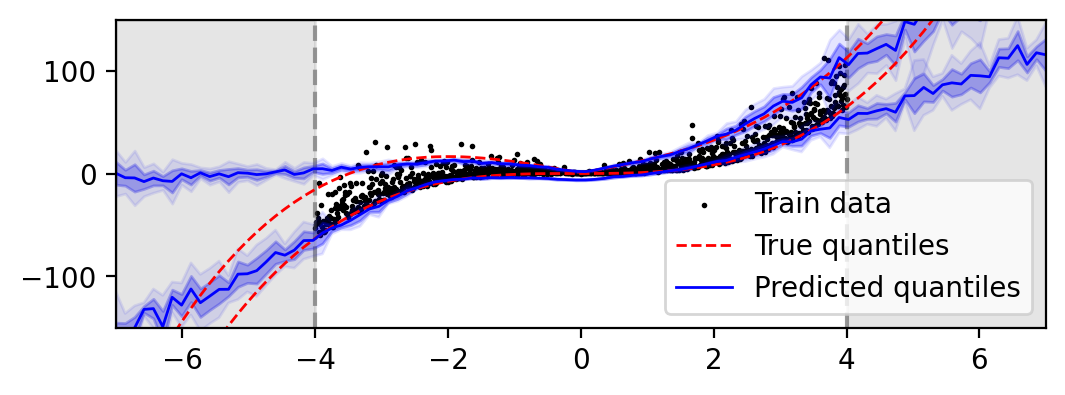

In [47]:
evi_preds = Drop.predict(x_plot)*y_train_scale + y_train_mu
_, sigma = Drop.get_mu_sigma(x_plot)
sigma = sigma*y_train_scale
var_ = Drop.get_uncertainties(x_plot)*y_train_scale

plt.figure(figsize=(6,2), dpi=200)
plt.scatter(x_test*x_train_scale+x_train_mu, y_test * y_train_scale + y_train_mu, s=1.0, c='black', label='Train data')
#plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,0], c='red', linewidth=1, linestyle='--', label='True quantiles')
plt.plot(x_plot*x_train_scale+x_train_mu, y_plot_dist[:,1], c='red', linewidth=1, linestyle='--')

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,1], c='blue', linewidth=1)
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-sigma[:,1], evi_preds[:,1]+sigma[:,1], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-var_[:,1], evi_preds[:,1]+var_[:,1], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,1]-2*var_[:,1], evi_preds[:,1]+2*var_[:,1], color='blue', alpha=0.1)

plt.plot(x_plot*x_train_scale+x_train_mu, evi_preds[:,0], c='blue', linewidth=1, label='Predicted quantiles')
#plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-sigma[:,0], evi_preds[:,0]+sigma[:,0], color='green', alpha=0.5)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-var_[:,0], evi_preds[:,0]+var_[:,0], color='blue', alpha=0.3)
plt.fill_between((x_plot*x_train_scale+x_train_mu)[:,0], evi_preds[:,0]-2*var_[:,0], evi_preds[:,0]+2*var_[:,0], color='blue', alpha=0.1)

plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)

# fill gray for x < -4
plt.fill_between([-7, -4], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.fill_between([4, 7], [-150, -150], [150, 150], color='gray', alpha=0.2)
plt.ylim(-150, 150)
plt.xlim(-7, 7)
plt.legend(loc='lower right')
plt.savefig('qualitiv_drop_epi.pdf', bbox_inches='tight')

Evidence


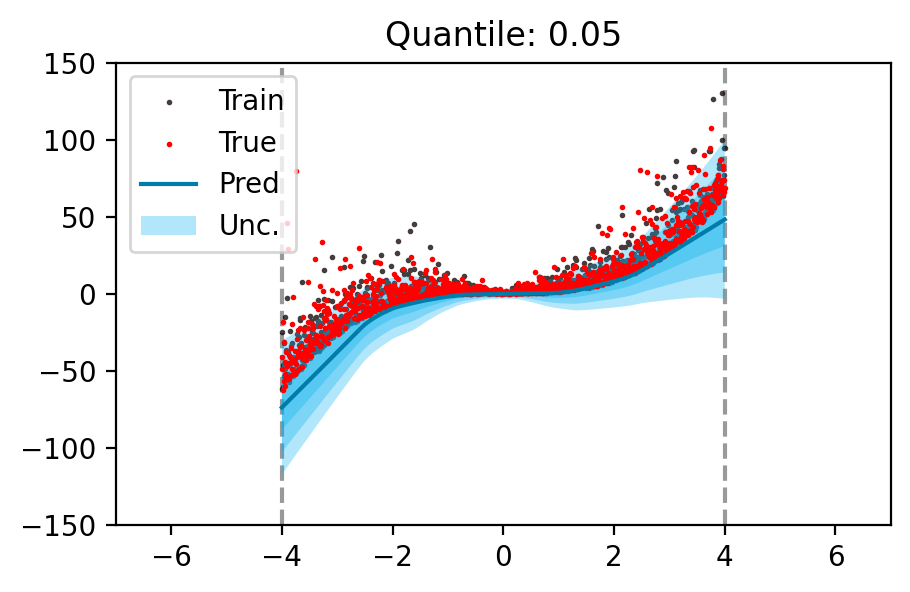

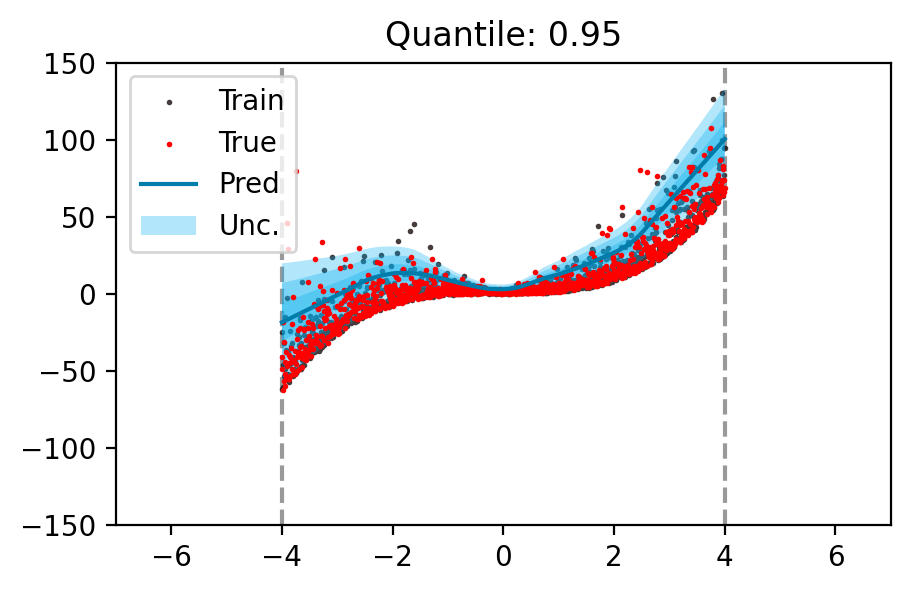

Dropout


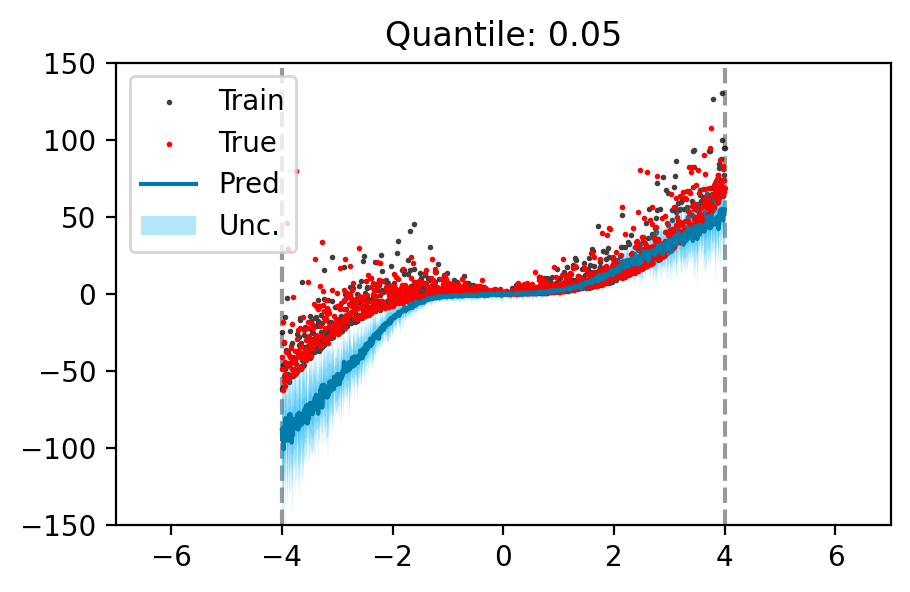

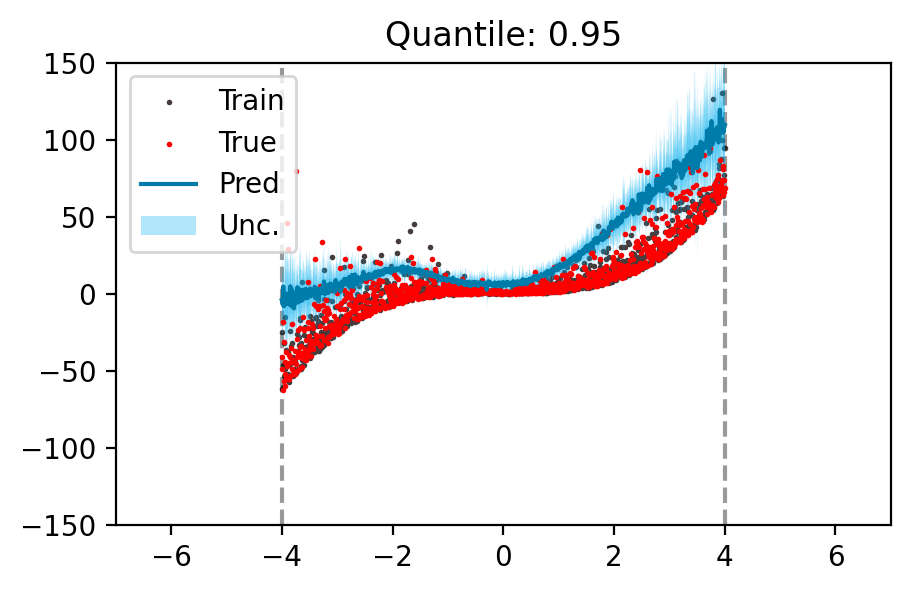

Ensemble


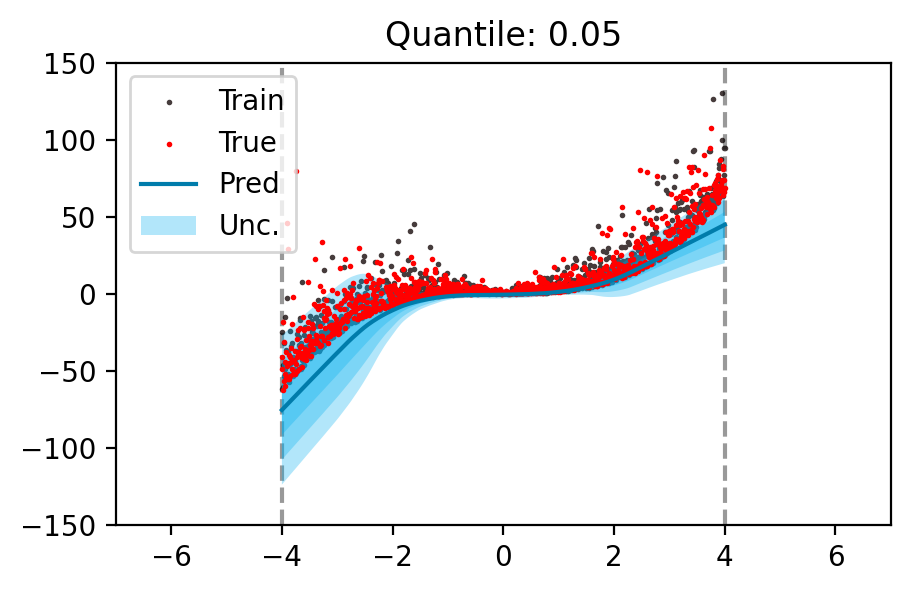

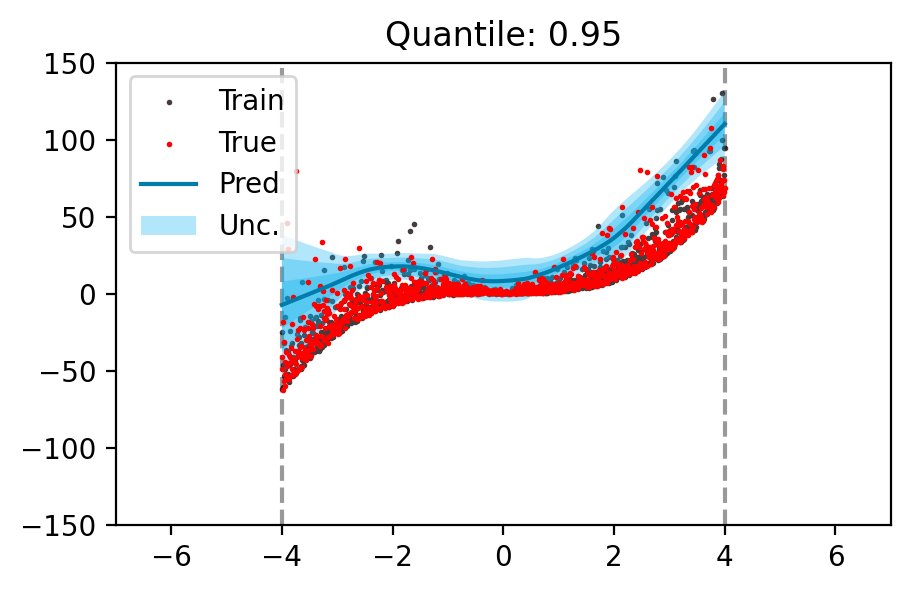

In [41]:
print("Evidence")
plot_q(x_train, y_train, x_test, y_test, Evi)
print("Dropout")
plot_q(x_train, y_train, x_test, y_test, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_test , y_test, Ense)

#print("Ensemble")
#plot_q(x_train, y_train, x_test , y_test, eve_g)


Evidence


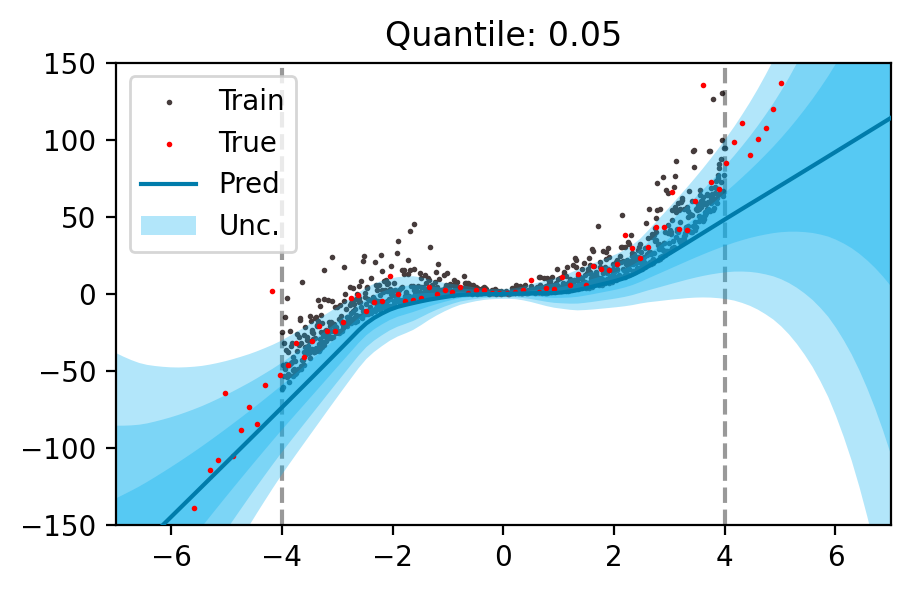

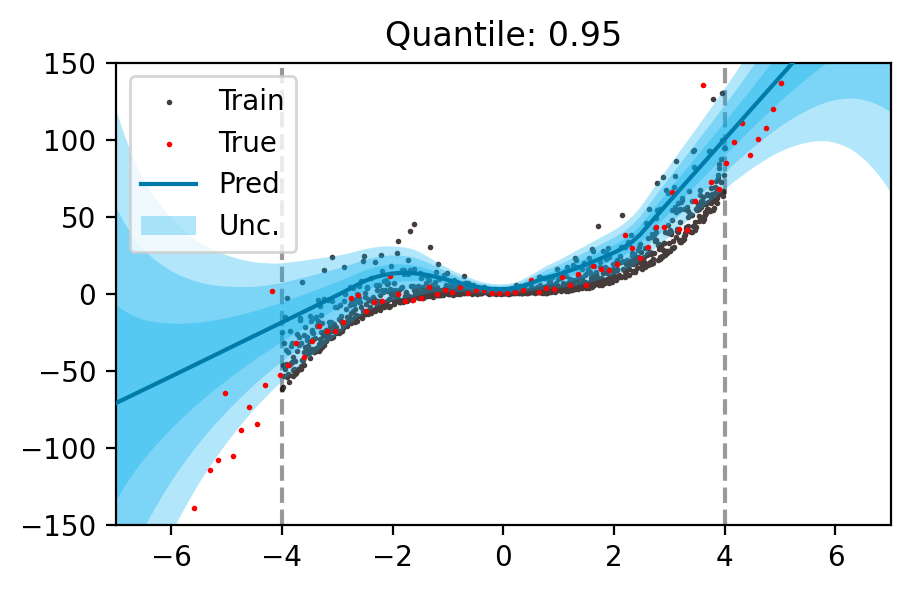

Dropout


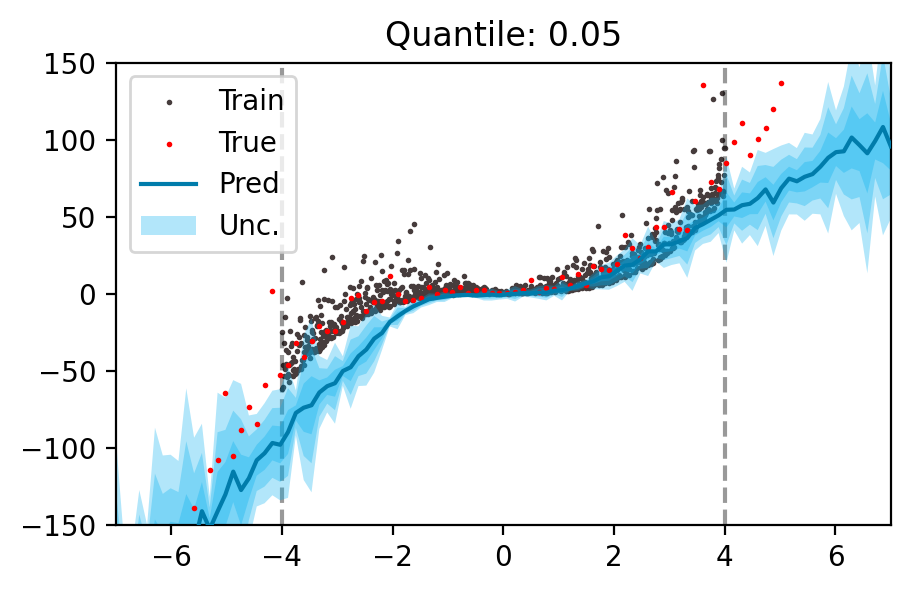

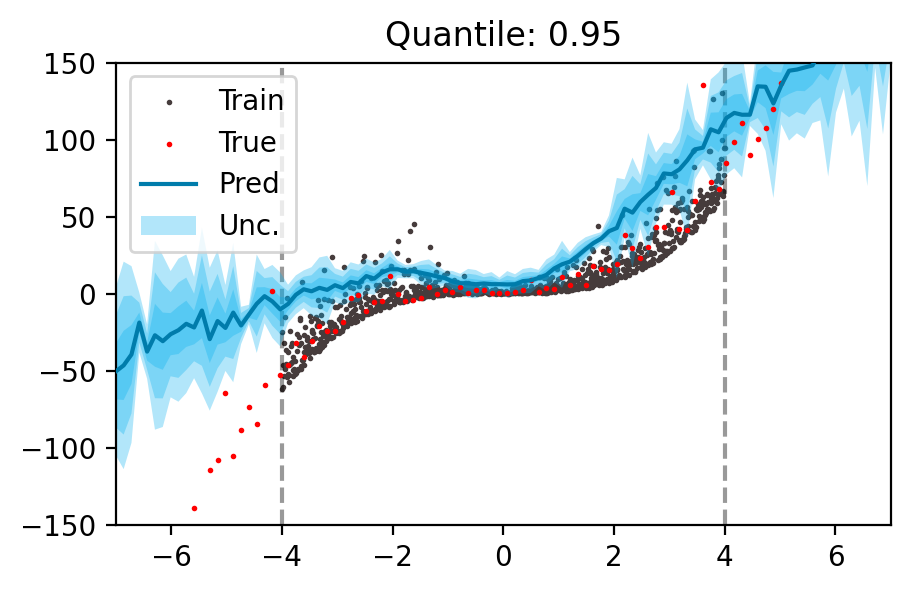

Ensemble


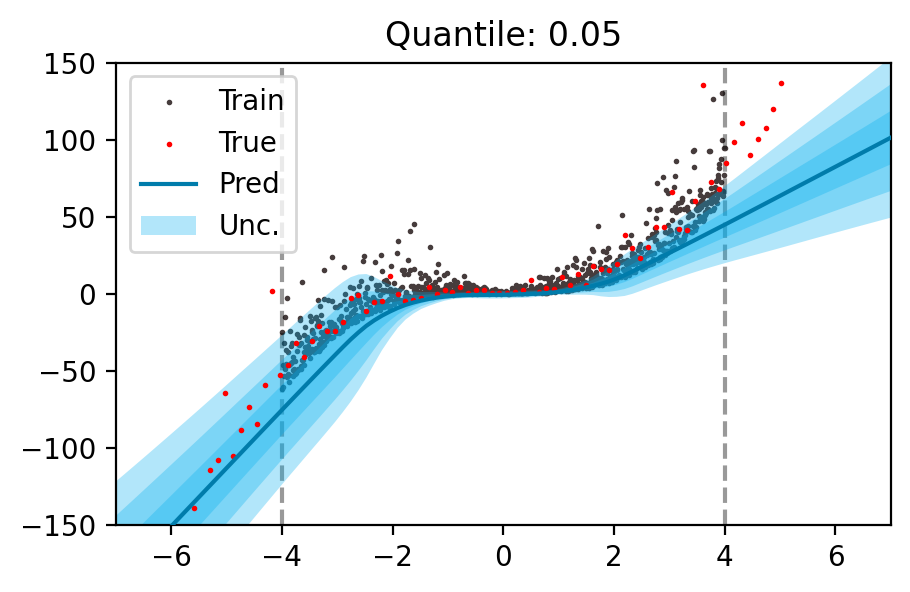

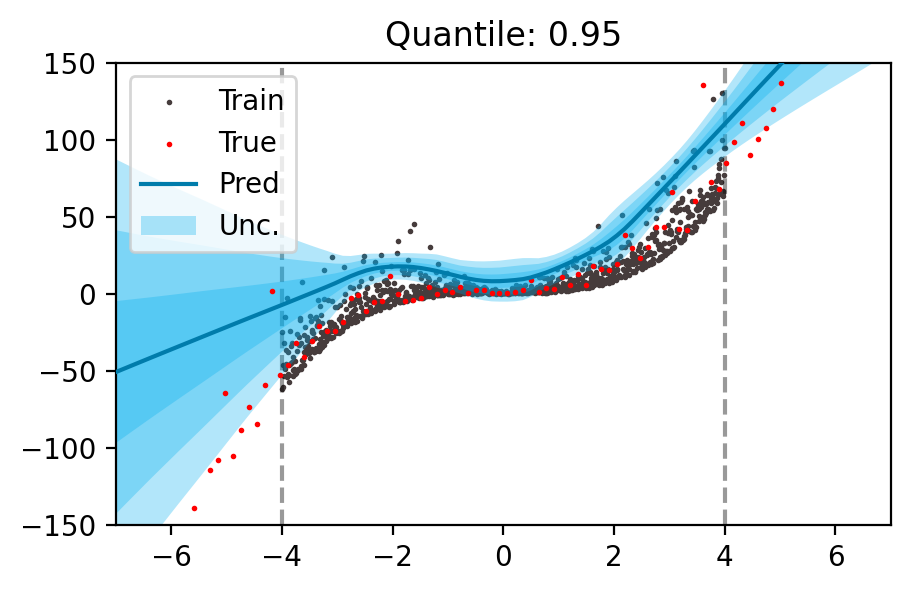

In [42]:
print("Evidence")
plot_q(x_train, y_train, x_plot, y_plot, Evi)
print("Dropout")
plot_q(x_train, y_train, x_plot, y_plot, Drop)
print("Ensemble")
plot_q(x_train, y_train, x_plot, y_plot, Ense)

In [1]:
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from models.evidentalconv import ConvEvidental
from quantilelosses import *
import pickle

2023-07-28 09:14:18.952286: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-28 09:14:18.952316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
test = h5py.File("data/depth/depth_test.h5", "r")
ood = h5py.File('data/depth/apolloscape_test.h5', 'r')

In [3]:
x_test, y_test = (test["image"], test["depth"])
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)/255.
ood_x, ood_y = (ood["image"], ood["depth"])

2023-07-28 09:14:22.150976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 09:14:22.151894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 09:14:22.154060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-28 09:14:22.154148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-28 09:

In [4]:
evidental = h5py.File("results/depth/evidental_6.h5", "r")
dropout = h5py.File("results/depth/dropout_1.h5", "r")

In [5]:
evidental_q5 = tf.expand_dims(tf.convert_to_tensor((evidental.get('in_dist_mu')[:,:,:,0]), dtype=tf.float32), 3)
evidental_q95 = tf.expand_dims(tf.convert_to_tensor((evidental.get('in_dist_mu')[:,:,:,1]), dtype=tf.float32), 3)

In [6]:
print(evidental.keys())
print(dropout.keys())

<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>
<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>


In [7]:
def parse_ensemble():
    ensemble_1 = h5py.File("results/depth/ensemble_7.h5", "r")
    ensemble_2 = h5py.File("results/depth/ensemble_2.h5", "r")
    ensemble_3 = h5py.File("results/depth/ensemble_3.h5", "r")
    ensemble_4 = h5py.File("results/depth/ensemble_4.h5", "r")
    ensemble_5 = h5py.File("results/depth/ensemble_5.h5", "r")

    return {
        'in_dist_mu': get_mu('in_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_mu': get_mu('out_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'in_dist_sigma': get_mu('in_dist_sigma', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_sigma': get_mu('out_dist_sigma', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'in_dist_unc': get_std('in_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5),
        'out_dist_unc': get_std('out_dist_mu', ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5)
    }
    

In [8]:
def get_mu(colname, ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5):
    ense_1 = np.array(ensemble_1[colname][:], dtype=np.float32)
    ense_2 = np.array(ensemble_2[colname][:], dtype=np.float32)
    ense_3 = np.array(ensemble_3[colname][:], dtype=np.float32)
    ense_4 = np.array(ensemble_4[colname][:], dtype=np.float32)
    ense_5 = np.array(ensemble_5[colname][:], dtype=np.float32)
    return np.mean([ense_1, ense_2, ense_3, ense_4, ense_5], axis=0)

def get_std(colname, ensemble_1, ensemble_2, ensemble_3, ensemble_4, ensemble_5):
    ense_1 = np.array(ensemble_1[colname][:], dtype=np.float32)
    ense_2 = np.array(ensemble_2[colname][:], dtype=np.float32)
    ense_3 = np.array(ensemble_3[colname][:], dtype=np.float32)
    ense_4 = np.array(ensemble_4[colname][:], dtype=np.float32)
    ense_5 = np.array(ensemble_5[colname][:], dtype=np.float32)
    return np.std([ense_1, ense_2, ense_3, ense_4, ense_5], axis=0)

In [9]:
ensemble = parse_ensemble()

In [10]:
print(evidental.keys())
print(dropout.keys())
print(ensemble.keys())

<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>
<KeysViewHDF5 ['in_dist_mu', 'in_dist_sigma', 'in_dist_unc', 'out_dist_mu', 'out_dist_sigma', 'out_dist_unc']>
dict_keys(['in_dist_mu', 'out_dist_mu', 'in_dist_sigma', 'out_dist_sigma', 'in_dist_unc', 'out_dist_unc'])


In [11]:
# combine predictions from all the ensembles


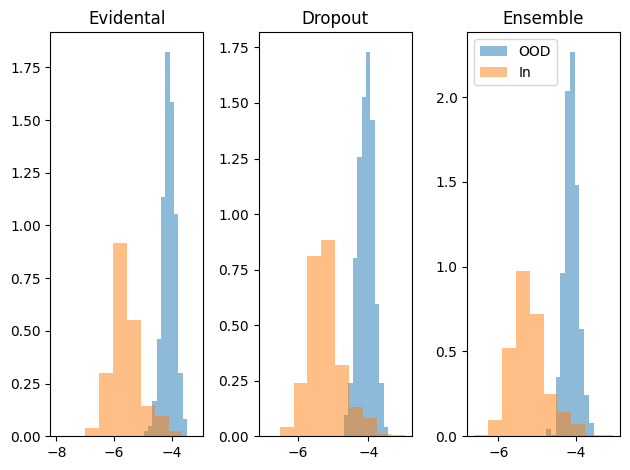

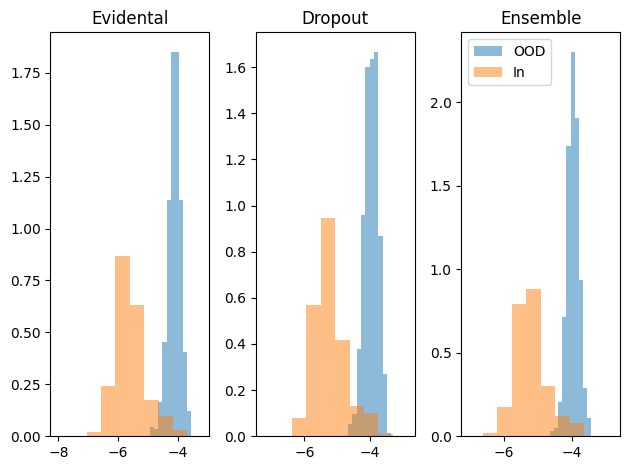

In [12]:
ev_ood_unc = np.mean(evidental['out_dist_sigma'], axis=(1, 2))
ev_in_unc = np.mean(evidental['in_dist_sigma'], axis=(1, 2))

dr_ood_unc = np.mean(dropout['out_dist_sigma'], axis=(1, 2))
dr_in_unc = np.mean(dropout['in_dist_sigma'], axis=(1, 2))

en_ood_unc = np.mean(ensemble['out_dist_sigma'], axis=(1, 2))
en_in_unc = np.mean(ensemble['in_dist_sigma'], axis=(1, 2))

ev_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_ood_unc**2))
ev_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_in_unc**2))

dr_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_ood_unc**2))
dr_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_in_unc**2))

en_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_ood_unc**2))
en_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_in_unc**2))

for i in range(2):
    # make 3 histogram side by side
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)

    axs[0].hist(ev_ood_entr[:,i], bins=10, alpha=0.5, label='OOD', density=True)
    axs[0].hist(ev_in_entr[:,i], bins=10, alpha=0.5, label='In', density=True)
    axs[0].set_title('Evidental')

    axs[1].hist(dr_ood_entr[:,i], bins=10, alpha=0.5, label='OOD', density=True)
    axs[1].hist(dr_in_entr[:,i], bins=10, alpha=0.5, label='In', density=True)
    axs[1].set_title('Dropout')

    axs[2].hist(en_ood_entr[:,i], bins=10, alpha=0.5, label='OOD', density=True)
    axs[2].hist(en_in_entr[:,i], bins=10, alpha=0.5, label='In', density=True)
    axs[2].set_title('Ensemble')

    plt.legend()
    plt.show()

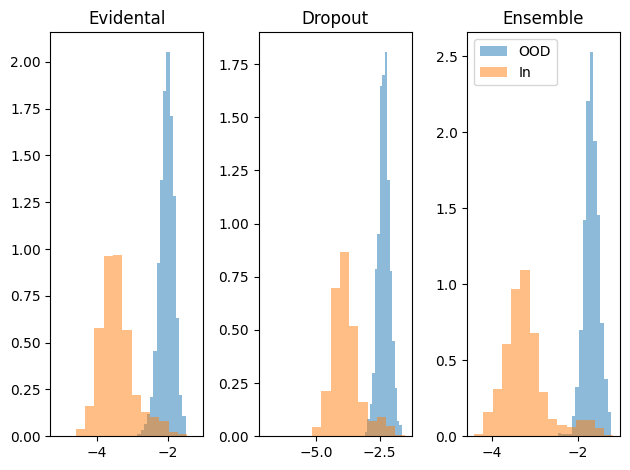

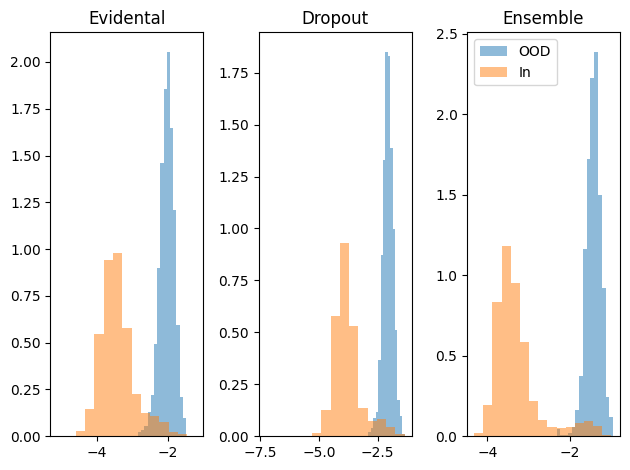

In [13]:
ev_ood_unc = np.mean(evidental['out_dist_unc'], axis=(1, 2))
ev_in_unc = np.mean(evidental['in_dist_unc'], axis=(1, 2))

dr_ood_unc = np.mean(dropout['out_dist_unc'], axis=(1, 2))
dr_in_unc = np.mean(dropout['in_dist_unc'], axis=(1, 2))

en_ood_unc = np.mean(ensemble['out_dist_unc'], axis=(1, 2))
en_in_unc = np.mean(ensemble['in_dist_unc'], axis=(1, 2))

ev_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_ood_unc**2))
ev_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_in_unc**2))

dr_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_ood_unc**2))
dr_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(dr_in_unc**2))

en_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_ood_unc**2))
en_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(en_in_unc**2))

for i in range(2):
    # make 3 histogram side by side
    fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True)

    axs[0].hist(ev_ood_entr[:,i], bins=15, alpha=0.5, label='OOD', density=True)
    axs[0].hist(ev_in_entr[:,i], bins=15, alpha=0.5, label='In', density=True)


    axs[0].set_title('Evidental')

    axs[1].hist(dr_ood_entr[:,i], bins=15, alpha=0.5, label='OOD', density=True)
    axs[1].hist(dr_in_entr[:,i], bins=15, alpha=0.5, label='In', density=True)
    axs[1].set_title('Dropout')

    axs[2].hist(en_ood_entr[:,i], bins=15, alpha=0.5, label='OOD', density=True)
    axs[2].hist(en_in_entr[:,i], bins=15, alpha=0.5, label='In', density=True)
    axs[2].set_title('Ensemble')

    plt.legend()
    plt.show()

In [14]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

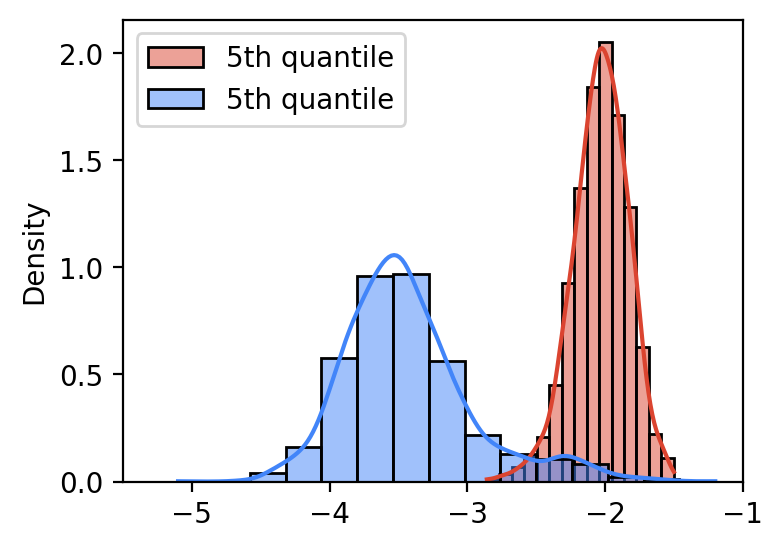

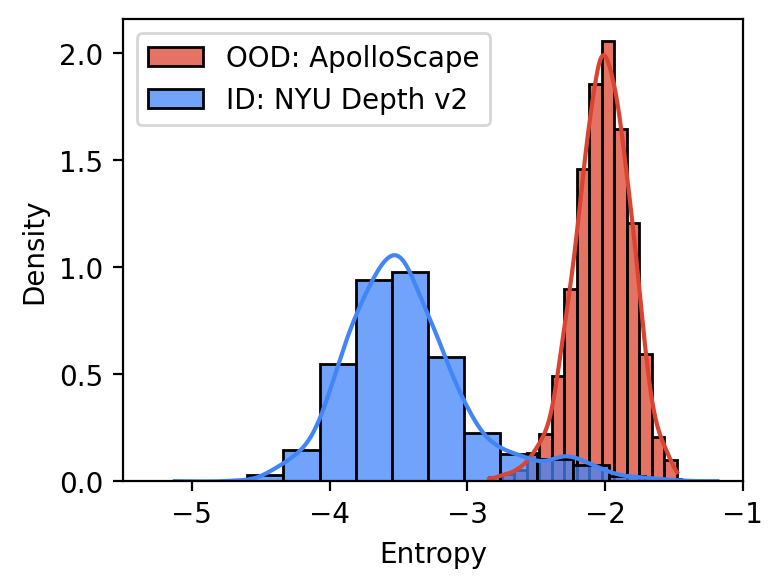

In [15]:
# plot histogram of entropy for evidential model for in and out of distribution
import seaborn as sns

ev_ood_unc = np.mean(evidental['out_dist_unc'], axis=(1, 2))
ev_in_unc = np.mean(evidental['in_dist_unc'], axis=(1, 2))


ev_ood_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_ood_unc**2))
ev_in_entr = 0.5*np.log(2*np.pi*np.exp(1.)*(ev_in_unc**2))

# set font size and style for AAAI paper
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams.update({'font.size': 10})
# set figure size to fit 1 column of AAAI paper


plt.style.use('default')
plt.rcParams.update({'font.size': 10})
width = 239.39438
#plt.rcParams["figure.figsize"] = (6,4)#set_size(width, 1.5)
plt.figure(figsize=(4,3), dpi=200)

# make histogram of evidental model out of
sns.histplot(ev_ood_entr[:,0], bins=15, alpha=0.5, label='5th quantile', color='#DB4430', stat='density', kde=True)

sns.histplot(ev_in_entr[:,0], bins=15, alpha=0.5, label='5th quantile', color='#4285F9', stat='density', kde=True)
plt.xlim(-5.5, -1.0)
plt.legend( loc='upper left')
plt.savefig('evidental_entr_q5.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,3), dpi=200)
sns.histplot(ev_ood_entr[:,1], bins=15, alpha=0.75, label='OOD: ApolloScape', color='#DB4430', stat='density', kde=True)
sns.histplot(ev_in_entr[:,1], bins=15, alpha=0.75, label='ID: NYU Depth v2', color='#4285F9', stat='density', kde=True)
plt.xlim(-5.5, -1.0)
plt.xlabel('Entropy')
plt.legend( loc='upper left')
plt.savefig('evidental_entr_q95.pdf', bbox_inches='tight')
plt.show()




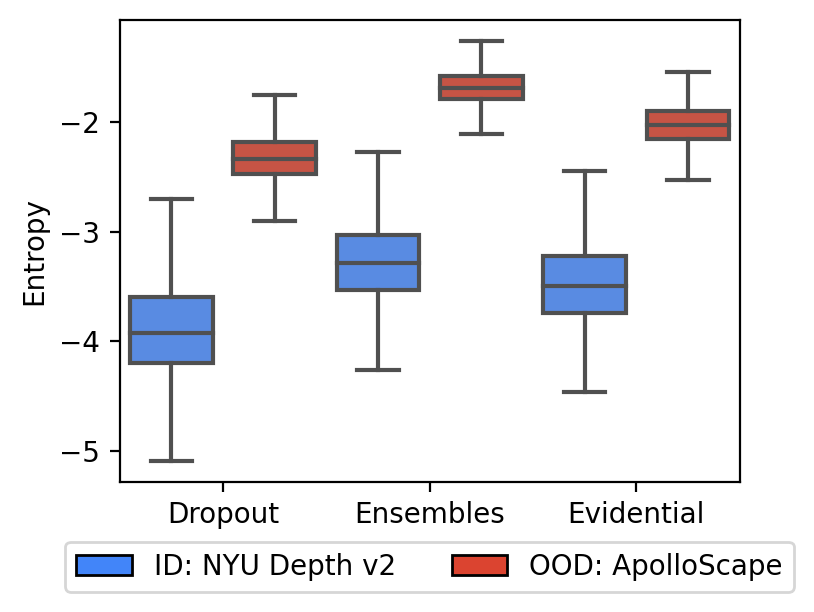

In [16]:
# set font size and style for AAAI paper
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcParams.update({'font.size': 10})
# set figure size to fit 1 column of AAAI paper


plt.style.use('default')
plt.rcParams.update({'font.size': 10})
width = 239.39438
#plt.rcParams["figure.figsize"] = (6,4)#set_size(width, 1.5)
plt.figure(figsize=(4,3), dpi=200)
#fig, ax = plt.subplots(figsize=set_size(width,1.5), frameon=False)


# make boxplot where the colors are in distribituion or OOD, and the x axis is the method
sns.boxplot(data=[dr_in_entr[:,0], dr_ood_entr[:,0], en_in_entr[:,0], en_ood_entr[:,0],
                ev_in_entr[:,0], ev_ood_entr[:,0]], showfliers=False,
            palette=['#4285F9', '#DB4430', '#4285F9', '#DB4430', '#4285F9', '#DB4430'])



# add legend for the colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(facecolor='#4285F9', label='ID: NYU Depth v2', edgecolor='black')
orange_patch = mpatches.Patch(facecolor='#DB4430', label='OOD: ApolloScape', edgecolor='black')
# place legend below the x-axis such that it macthes the heights of the other plots
plt.legend(handles=[blue_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)
#plt.legend(handles=[blue_patch, orange_patch], loc='lower right', ncol=2)


plt.xticks([0.5,2.5,4.5], ['Dropout', 'Ensembles', 'Evidential'])
plt.ylabel('Entropy')
plt.savefig('depth_entropy.pdf', bbox_inches='tight')
plt.show()

In [17]:
# add smooth pdf the histograms with a kde
#sns.histplot(ev_ood_entr[:,i], label='OOD: ApolloScape', kde=True, stat="density", bins=15, color='#DB4430')
#sns.histplot(ev_in_entr[:,i], label='In: NYU Depth v2', kde=True, stat="density", bins=15, color='#4285F9')
#plt.xlabel('Entropy')
#plt.legend(loc = 'upper left')
#plt.savefig('depth_entropy_evidental.pdf', bbox_inches='tight')

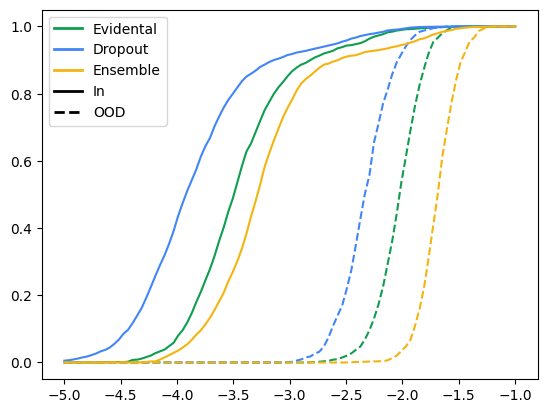

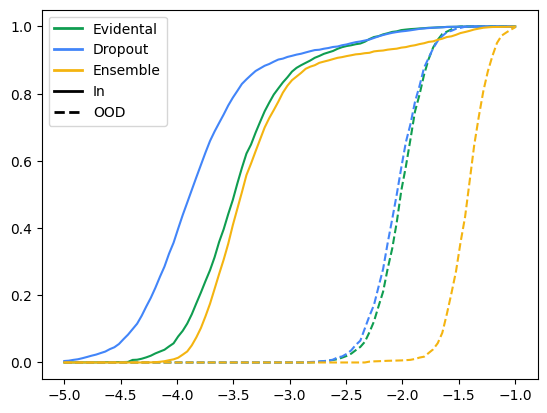

In [18]:
#unc_ = np.linspace(ev_ood_entr[:,0].min(), ev_ood_entr[:,0].max(), 100)
import scipy
for i in range(0,2):
    #unc_ = np.linspace(ev_in_entr[:,i].min(), ev_in_entr[:,i].max(), 100)
    #unc_ = np.linspace(ev_in_entr[:,i].min(), -1.0, 100)
    unc_ = np.linspace(-5.0, -1.0, 100)
    unc = np.sort(ev_ood_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, color='#0F9D50', linestyle='--')
    unc = np.sort(ev_in_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, label='Evidental', color='#0F9D50')

    unc = np.sort(dr_ood_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, color='#4285F9', linestyle='--')
    unc = np.sort(dr_in_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, label='Dropout', color='#4285F9')

    unc = np.sort(en_ood_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, color='#F4B410', linestyle='--')
    unc = np.sort(en_in_entr[:,i])
    prob = np.linspace(0, 1, unc.shape[0])
    f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
    prob_ = f_cdf(unc_)
    plt.plot(unc_, prob_, label='Ensemble', color='#F4B410')


    # make custom legend label
    custom_lines = [plt.Line2D([0], [0], color='#0F9D50', lw=2),
                    plt.Line2D([0], [0], color='#4285F9', lw=2),
                    plt.Line2D([0], [0], color='#F4B410', lw=2),
                    plt.Line2D([0], [0], color='black', lw=2),
                    plt.Line2D([0], [0], color='black', lw=2, linestyle='--')]
    plt.legend(custom_lines, ['Evidental', 'Dropout', 'Ensemble', 'In', 'OOD'])
                

#    plt.legend()
    plt.show()


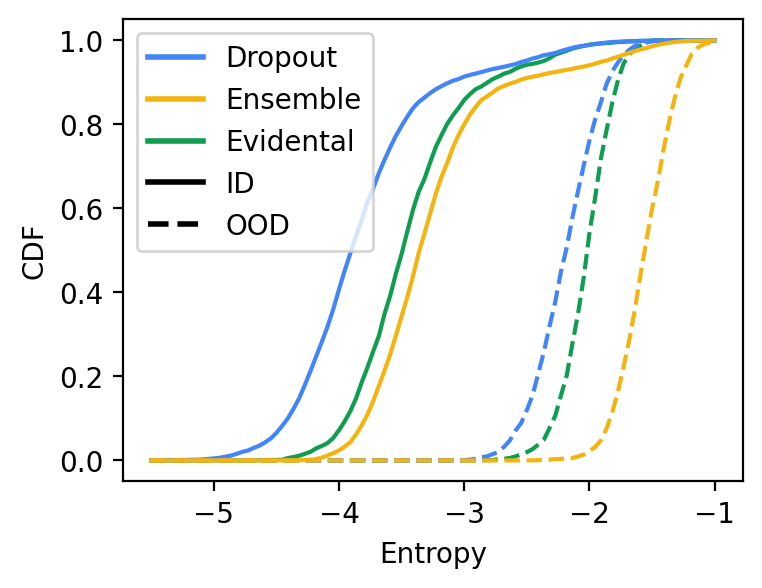

In [19]:
#unc_ = np.linspace(ev_ood_entr[:,0].min(), ev_ood_entr[:,0].max(), 100)
import scipy
#unc_ = np.linspace(ev_in_entr[:,i].min(), ev_in_entr[:,i].max(), 100)
#unc_ = np.linspace(ev_in_entr[:,i].min(), -1.0, 100)
plt.figure(figsize=(4,3), dpi=200)
unc_ = np.linspace(-5.5, -1.0, 100)
unc = np.sort(ev_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, color='#0F9D50', linestyle='--')
unc = np.sort(ev_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, label='Evidental', color='#0F9D50')

unc = np.sort(dr_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, color='#4285F9', linestyle='--')
unc = np.sort(dr_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, label='Dropout', color='#4285F9')

unc = np.sort(en_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, color='#F4B410', linestyle='--')
unc = np.sort(en_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
plt.plot(unc_, prob_, label='Ensemble', color='#F4B410')


# make custom legend label
custom_lines = [plt.Line2D([0], [0], color='#4285F9', lw=2),
                plt.Line2D([0], [0], color='#F4B410', lw=2),
                plt.Line2D([0], [0], color='#0F9D50', lw=2),
                plt.Line2D([0], [0], color='black', lw=2),
                plt.Line2D([0], [0], color='black', lw=2, linestyle='--')]
plt.legend(custom_lines, ['Dropout', 'Ensemble','Evidental', 'ID', 'OOD'])
            
plt.ylabel('CDF')
plt.xlabel('Entropy')
#plt.xticks(np.arange(-5.5, -1.0, 0.5))
plt.savefig('depth_entropy_cdf.pdf', bbox_inches='tight')
plt.show()


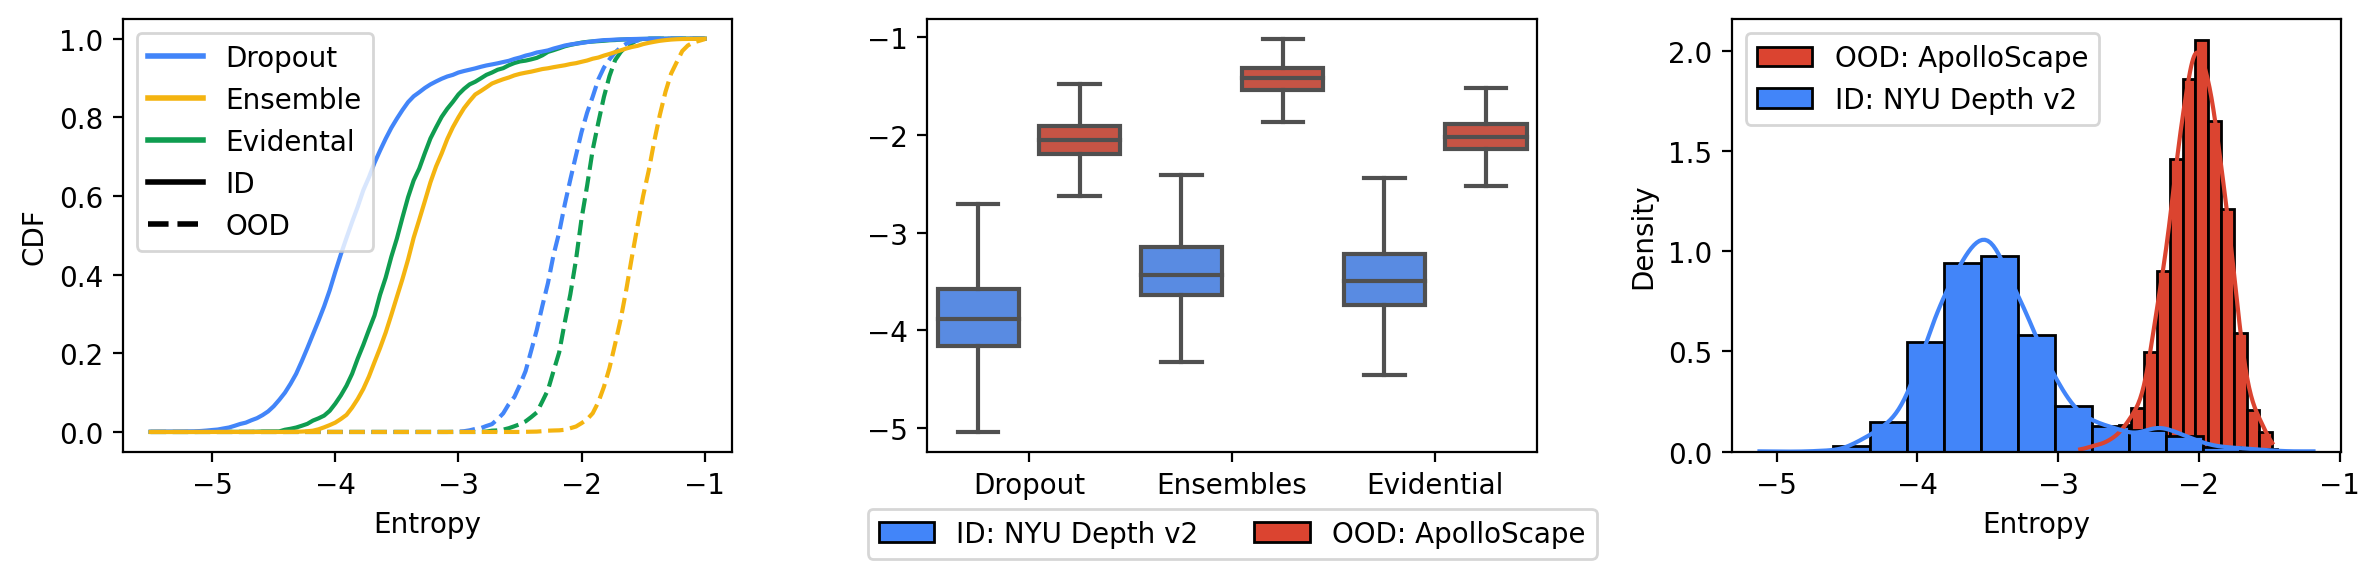

In [41]:
#plt.figure(figsize=(4,3), dpi=200)
fig, axs = plt.subplots(1,3, tight_layout=True, figsize=(12,3), dpi=200)
# create 3 side by side images of the uncertainty
unc_ = np.linspace(-5.5, -1.0, 100)
unc = np.sort(ev_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, color='#0F9D50', linestyle='--')
unc = np.sort(ev_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, label='Evidental', color='#0F9D50')

unc = np.sort(dr_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, color='#4285F9', linestyle='--')
unc = np.sort(dr_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, label='Dropout', color='#4285F9')

unc = np.sort(en_ood_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, color='#F4B410', linestyle='--')
unc = np.sort(en_in_entr.flatten())
prob = np.linspace(0, 1, unc.shape[0])
f_cdf = scipy.interpolate.interp1d(unc, prob, fill_value=(0.,1.), bounds_error=False)
prob_ = f_cdf(unc_)
axs[0].plot(unc_, prob_, label='Ensemble', color='#F4B410')


axs[0].set_xlabel('Entropy')
axs[0].set_ylabel('CDF')

custom_lines = [plt.Line2D([0], [0], color='#4285F9', lw=2),
                plt.Line2D([0], [0], color='#F4B410', lw=2),
                plt.Line2D([0], [0], color='#0F9D50', lw=2),
                plt.Line2D([0], [0], color='black', lw=2),
                plt.Line2D([0], [0], color='black', lw=2, linestyle='--')]
axs[0].legend(custom_lines, ['Dropout', 'Ensemble','Evidental', 'ID', 'OOD'])

#axs[0].legend(loc='upper left')

#axs[0].imshow(x_test[image_id,:,:])
#axs[0].plot(unc_, prob_, label='Ensemble', color='#F4B410')
#axs[0].set_title('Original')

#axs[1].imshow(evidental['in_dist_sigma'][image_id,:,:,i]*np.float64(255.))
#axs[1].set_title('Evidental')
# make boxplot where the colors are in distribituion or OOD, and the x axis is the method
sns.boxplot(data=[dr_in_entr[:,1], dr_ood_entr[:,1], en_in_entr[:,1], en_ood_entr[:,1],
            ev_in_entr[:,1], ev_ood_entr[:,1]], showfliers=False, ax=axs[1],
        palette=['#4285F9', '#DB4430', '#4285F9', '#DB4430', '#4285F9', '#DB4430'])

# add legend for the colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(facecolor='#4285F9', label='ID: NYU Depth v2', edgecolor='black')
orange_patch = mpatches.Patch(facecolor='#DB4430', label='OOD: ApolloScape', edgecolor='black')
# place legend below the x-axis such that it macthes the heights of the other plots
axs[1].legend(handles=[blue_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)

# set x-ticks on axs[1] to be the method names
#axs[1].set_xticklabels(['Dropout', 'Ensemble', 'Evidental'])

axs[1].set_xticks([0.5,2.5,4.5], ['Dropout', 'Ensembles', 'Evidential'])


# add legend for the colors
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(facecolor='#4285F9', label='ID: NYU Depth v2', edgecolor='black')
orange_patch = mpatches.Patch(facecolor='#DB4430', label='OOD: ApolloScape', edgecolor='black')
# place legend below the x-axis such that it macthes the heights of the other plots
#plt.legend(handles=[blue_patch, orange_patch], loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)
#plt.legend(handles=[blue_patch, orange_patch], loc='lower right', ncol=2)

#axs[3].imshow(ensemble['in_dist_sigma'][image_id,:,:,i])
#axs[3].set_title('Ensemble')
sns.histplot(ev_ood_entr[:,1],ax=axs[2], bins=15, alpha=1.0, label='OOD: ApolloScape', color='#DB4430', stat='density', kde=True)
sns.histplot(ev_in_entr[:,1],ax=axs[2], bins=15, alpha=1.0, label='ID: NYU Depth v2', color='#4285F9', stat='density', kde=True)
axs[2].set_xlabel('Entropy')
axs[2].legend(loc='upper left')
#axs[3].xlim(-5.5, -1.0)
#axs[3].xlabel('Entropy')
#axs[3].legend( loc='upper left')
#plt.savefig('evidental_entr_q95.pdf', bbox_inches='tight')
#plt.show()
plt.savefig("depth_entropy_complete.pdf", bbox_inches='tight')
plt.show()

In [ ]:
import scipy

In [ ]:
ev_ood_entr.flatten().shape

(2000,)

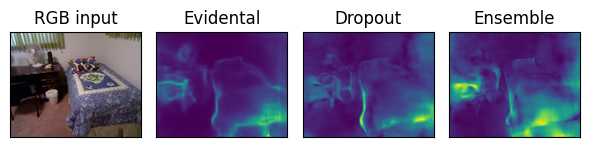

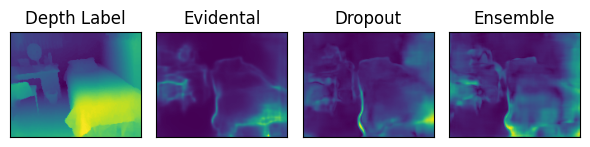

In [ ]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)
    # remove x lables and y labels from the figures
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        

    if i == 1:
        axs[0].imshow(y_test[image_id])
        axs[0].set_title('Depth Label')
    else:
        axs[0].imshow(x_test[image_id,:,:])
        axs[0].set_title('RGB input')

    axs[1].imshow(evidental['in_dist_unc'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['in_dist_unc'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['in_dist_unc'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

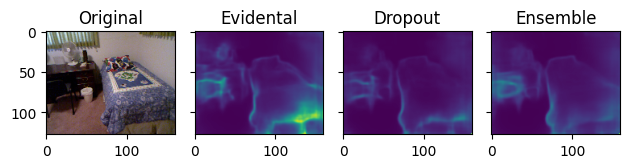

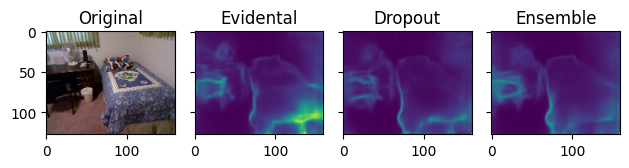

In [ ]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(x_test[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['in_dist_sigma'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['in_dist_sigma'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['in_dist_sigma'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

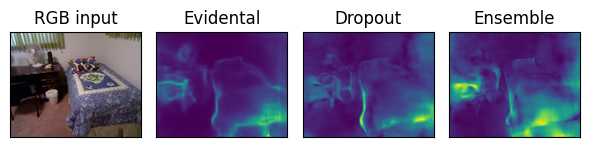

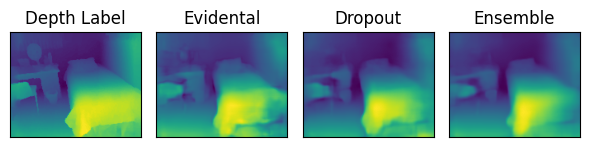

In [ ]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)
    # remove x lables and y labels from the figures
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        

    if i == 1:
        axs[0].imshow(y_test[image_id])
        axs[0].set_title('Depth Label')
    else:
        axs[0].imshow(x_test[image_id,:,:])
        axs[0].set_title('RGB input')


    if i == 1:
        axs[1].imshow(evidental['in_dist_mu'][image_id,:,:,0]*np.float64(255.))
    else:
        axs[1].imshow(evidental['in_dist_unc'][image_id,:,:,0]*np.float64(255.))
    axs[1].set_title('Evidental')

    if i == 1:
        axs[2].imshow(dropout['in_dist_mu'][image_id,:,:,0]*np.float64(255.))
    else:
        axs[2].imshow(dropout['in_dist_unc'][image_id,:,:,0]*np.float64(255.))
    axs[2].set_title('Dropout')

    if i == 1:
        axs[3].imshow(ensemble['in_dist_mu'][image_id,:,:,0]*np.float64(255.))
    else:
        axs[3].imshow(ensemble['in_dist_unc'][image_id,:,:,0]*np.float64(255.))
    axs[3].set_title('Ensemble')

    plt.show()

In [ ]:
plt.imshow(evidental['in_dist_mu'][image_id,:,:,1]*np.float64(255.)-evidental['in_dist_mu'][image_id,:,:,0]*np.float64(255.))

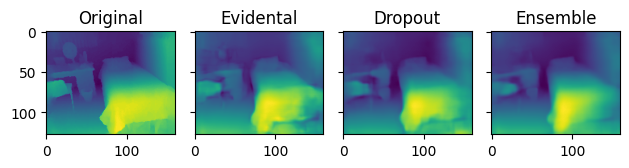

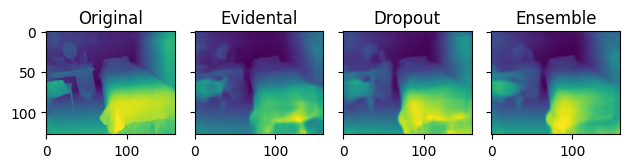

In [61]:
# create 3 side by side images of the uncertainty
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(y_test[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['in_dist_mu'][image_id,:,:,i])
    axs[1].set_title('Evidental')
    axs[2].imshow(dropout['in_dist_mu'][image_id,:,:,i])
    axs[2].set_title('Dropout')
    axs[3].imshow(ensemble['in_dist_mu'][image_id,:,:,i])
    axs[3].set_title('Ensemble')
    plt.show()

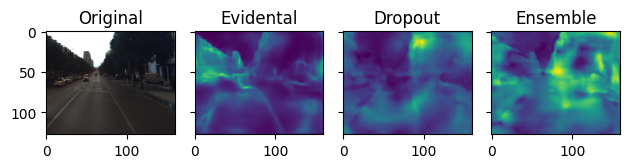

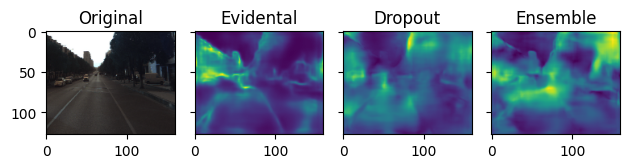

In [62]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(ood_x[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['out_dist_unc'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['out_dist_unc'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['out_dist_unc'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

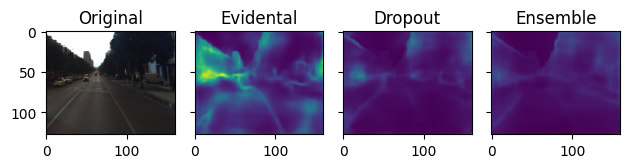

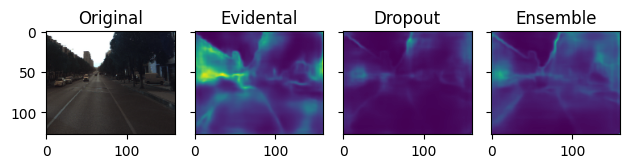

In [63]:
# create 3 side by side images of the uncertainty
image_id = 1
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(ood_x[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['out_dist_sigma'][image_id,:,:,i]*np.float64(255.))
    axs[1].set_title('Evidental')

    axs[2].imshow(dropout['out_dist_sigma'][image_id,:,:,i])
    axs[2].set_title('Dropout')

    axs[3].imshow(ensemble['out_dist_sigma'][image_id,:,:,i])
    axs[3].set_title('Ensemble')

    plt.show()

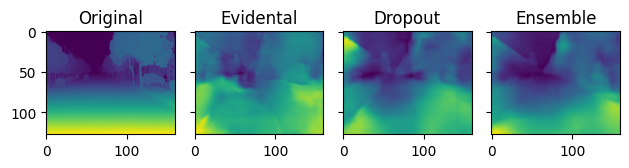

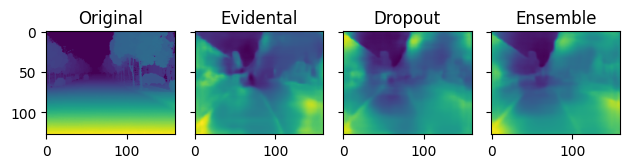

In [64]:
# create 3 side by side images of the uncertainty
for i in range(2):
    fig, axs = plt.subplots(1,4, sharey=True, tight_layout=True)

    axs[0].imshow(ood_y[image_id,:,:])
    axs[0].set_title('Original')

    axs[1].imshow(evidental['out_dist_mu'][image_id,:,:,i])
    axs[1].set_title('Evidental')
    axs[2].imshow(dropout['out_dist_mu'][image_id,:,:,i])
    axs[2].set_title('Dropout')
    axs[3].imshow(ensemble['out_dist_mu'][image_id,:,:,i])
    axs[3].set_title('Ensemble')
    plt.show()

In [49]:
# Create mosaic with 5x5 rows of images.
# The first row is the original image, the second row is the evidental uncertainty, the third row is the dropout uncertainty, the fourth row is the ensemble uncertainty, and the fifth row is the ground truth depth.
# The columns are the different images in the dataset.
# The first column is the original image, the second column is the evidental uncertainty, the third column is the dropout uncertainty, the fourth column is the ensemble uncertainty, and the fifth column is the ground truth depth.
# The images are saved in the file 'depth_mosaic.png'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import matplotlib.lines as mlines



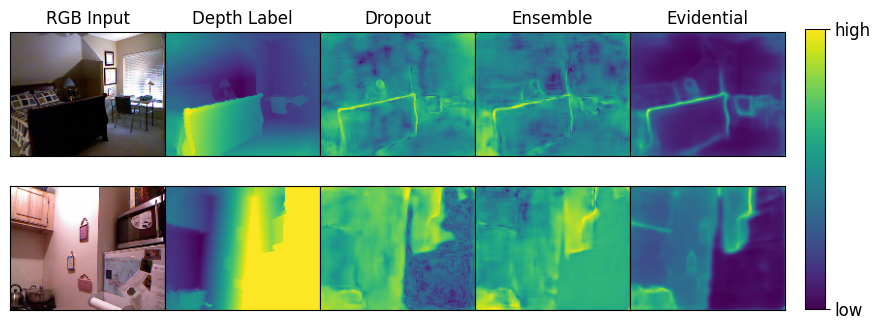

In [50]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 1, wspace=0.0, hspace=0.0)
ids = [1536, 2048]
for i in range(1):
    for j in range(1):
        inner_grid = gs[i, j].subgridspec(2, 5, wspace=0.0, hspace=0.0)
        axs = inner_grid.subplots()
        for (d, c), ax in np.ndenumerate(axs):
            if c == 0:
                ax.imshow(x_test[ids[d],:,:])
            elif c == 1:
                ax.imshow(y_test[ids[d],:,:])
            elif c == 2:
                ax.imshow(0.5*np.log(2*np.pi*np.exp(1.)*(dropout['in_dist_unc'][ids[d],:,:,0]**2)))
            elif c == 3:
                ax.imshow(0.5*np.log(2*np.pi*np.exp(1.)*(ensemble['in_dist_unc'][ids[d],:,:,0]**2)))
            else:
                ax.imshow(
                    0.5*np.log(2*np.pi*np.exp(1.)*(evidental['in_dist_unc'][ids[d],:,:,0]**2))
                    )
                
            ax.set_xticks([])
            ax.set_yticks([])

#put labels on top of the grid
for ax, col in zip(axs[0], ['RGB Input', 'Depth Label', 'Dropout', 'Ensemble', 'Evidential']):
    ax.set_title(col, fontsize=12)
    
# add colorbar on the right of the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
# set the labels of the colorbar, such that one end is low and the other is high
cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(['low', 'high'])
# add legend for the colors



plt.savefig('depth_mosaic_in_dist_unc.pdf', bbox_inches='tight')

plt.show()

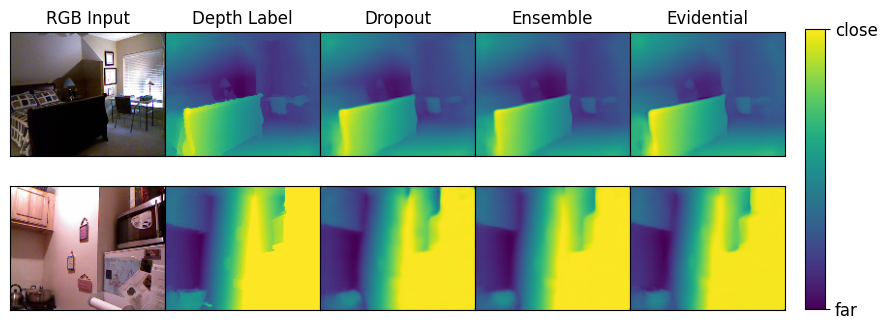

In [51]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 1, wspace=0.0, hspace=0.0)
ids = [1536, 2048]
for i in range(1):
    for j in range(1):
        inner_grid = gs[i, j].subgridspec(2, 5, wspace=0.0, hspace=0.0)
        axs = inner_grid.subplots()
        for (d, c), ax in np.ndenumerate(axs):
            if c == 0:
                ax.imshow(x_test[ids[d],:,:])
            elif c == 1:
                ax.imshow(y_test[ids[d],:,:])
            elif c == 2:
                ax.imshow(dropout['in_dist_mu'][ids[d],:,:,0])
            elif c == 3:
                ax.imshow(ensemble['in_dist_mu'][ids[d],:,:,0])
            else:
                ax.imshow(evidental['in_dist_mu'][ids[d],:,:,0])

                
            ax.set_xticks([])
            ax.set_yticks([])

#put labels on top of the grid
for ax, col in zip(axs[0], ['RGB Input', 'Depth Label', 'Dropout', 'Ensemble', 'Evidential']):
    ax.set_title(col, fontsize=12)


# add colorbar on the right of the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
# set the labels of the colorbar, such that one end is low and the other is high
cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(['far', 'close'])


plt.savefig('depth_mosaic_in_dist_mu.pdf', bbox_inches='tight')

plt.show()

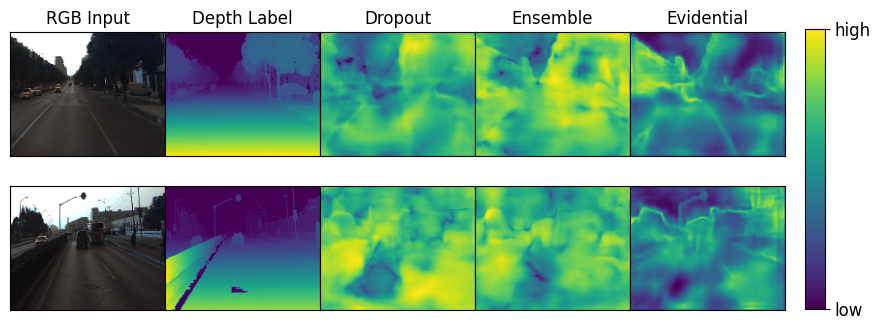

In [52]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 1, wspace=0.0, hspace=0.0)
ids = [1, 56]
for i in range(1):
    for j in range(1):
        inner_grid = gs[i, j].subgridspec(2, 5, wspace=0.0, hspace=0.0)
        axs = inner_grid.subplots()
        for (d, c), ax in np.ndenumerate(axs):
            if c == 0:
                ax.imshow(ood_x[ids[d],:,:])
            elif c == 1:
                ax.imshow(ood_y[ids[d],:,:])
            elif c == 2:
                ax.imshow(0.5*np.log(2*np.pi*np.exp(1.)*(dropout['out_dist_unc'][ids[d],:,:,0]**2)))
            elif c == 3:
                ax.imshow(0.5*np.log(2*np.pi*np.exp(1.)*(ensemble['out_dist_unc'][ids[d],:,:,0]**2)))
            else:
                ax.imshow(
                    0.5*np.log(2*np.pi*np.exp(1.)*(evidental['out_dist_unc'][ids[d],:,:,0]**2))
                    )
                
            ax.set_xticks([])
            ax.set_yticks([])

#put labels on top of the grid
for ax, col in zip(axs[0], ['RGB Input', 'Depth Label', 'Dropout', 'Ensemble', 'Evidential']):
    ax.set_title(col, fontsize=12)

# add colorbar on the right of the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
# set the labels of the colorbar, such that one end is low and the other is high
cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(['low', 'high'])


plt.savefig('depth_mosaic_out_dist_unc.pdf', bbox_inches='tight')

plt.show()

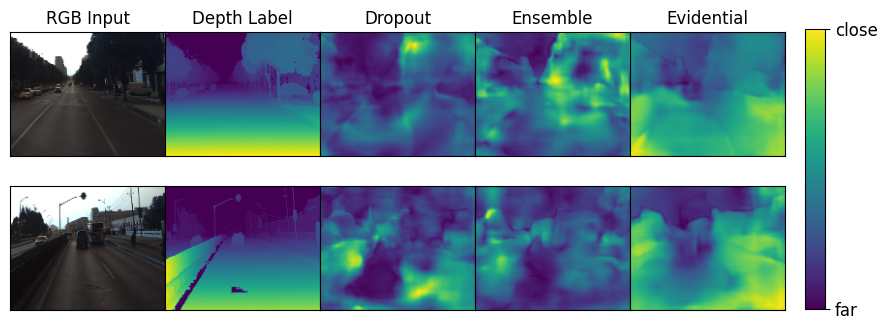

In [53]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 1, wspace=0.0, hspace=0.0)
ids = [1, 56]
for i in range(1):
    for j in range(1):
        inner_grid = gs[i, j].subgridspec(2, 5, wspace=0.0, hspace=0.0)
        axs = inner_grid.subplots()
        for (d, c), ax in np.ndenumerate(axs):
            if c == 0:
                ax.imshow(ood_x[ids[d],:,:])
            elif c == 1:
                ax.imshow(ood_y[ids[d],:,:])
            elif c == 2:
                ax.imshow(dropout['out_dist_unc'][ids[d],:,:,0])
            elif c == 3:
                ax.imshow(ensemble['out_dist_unc'][ids[d],:,:,0])
            else:
                ax.imshow(evidental['out_dist_mu'][ids[d],:,:,0])
                
            ax.set_xticks([])
            ax.set_yticks([])

#put labels on top of the grid
for ax, col in zip(axs[0], ['RGB Input', 'Depth Label', 'Dropout', 'Ensemble', 'Evidential']):
    ax.set_title(col, fontsize=12)

# add colorbar on the right of the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=0, vmax=1), cmap='viridis'), cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
# set the labels of the colorbar, such that one end is low and the other is high
cbar_ax.set_yticks([0, 1])
cbar_ax.set_yticklabels(['far', 'close'])



plt.savefig('depth_mosaic_out_dist_mu.pdf', bbox_inches='tight')

plt.show()

In [91]:
quantiles = [0.05, 0.95]
def tilted_loss(q, e):
        return tf.maximum(q*e, (q-1)*e)
        
def eval_conv(y, y_pred):
    loss = 0
    for i, q in enumerate(quantiles):
        loss += tilted_loss(q, y-tf.expand_dims(y_pred[:,:,:,i], 3))
    return tf.reduce_mean(loss)

def nll(y, preds, sigma):
    # compute the negative log likelihood of ALD
    loss = 0
    for i, q in enumerate(quantiles):
        first_part = tf.math.log((q*(1-q))/tf.expand_dims(sigma[:,:,:,i], 3))
        second_part = tilted_loss(q, (y-tf.expand_dims(preds[:,:,:,i], 3)))/tf.expand_dims(sigma[:,:,:,i], 3)
        loss -= tf.reduce_mean(-first_part+second_part)

    return loss#tf.reduce_mean(-first_part+second_part)


In [60]:
evidental = h5py.File("results/depth/evidental_7.h5", "r")
evidental_q5 = tf.expand_dims(tf.convert_to_tensor((evidental.get('in_dist_mu')[:,:,:,0]), dtype=tf.float32), 3)
evidental_q95 = tf.expand_dims(tf.convert_to_tensor((evidental.get('in_dist_mu')[:,:,:,1]), dtype=tf.float32), 3)

In [92]:
y_test.shape

TensorShape([3029, 128, 160, 1])

In [93]:
(evidental_q5 < y_test).numpy().mean()

0.9179686855191482

In [94]:
(evidental_q95 < y_test).numpy().mean()

0.1970045420311984

In [95]:
eval_conv(y_test, tf.convert_to_tensor((evidental.get('in_dist_mu')[:]), dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.009857496>

In [96]:
nll(y_test, tf.convert_to_tensor((evidental.get('in_dist_mu')[:]), dtype=tf.float32), tf.convert_to_tensor((evidental.get('in_dist_sigma')[:]), dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.56774163>

In [97]:
eval_conv(y_test, ensemble['in_dist_mu'])

<tf.Tensor: shape=(), dtype=float32, numpy=0.008888532>

In [98]:
nll(y_test, tf.convert_to_tensor(ensemble['in_dist_mu'], dtype=tf.float32), tf.convert_to_tensor(ensemble['in_dist_mu'], dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=-4.700836>

In [99]:
eval_conv(y_test, tf.convert_to_tensor((dropout.get('in_dist_mu')[:]), dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.009912759>

In [100]:
nll(y_test, tf.convert_to_tensor((dropout.get('in_dist_mu')[:]), dtype=tf.float32), tf.convert_to_tensor((dropout.get('in_dist_sigma')[:]), dtype=tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=2.332341>

In [101]:
from models.evidentalconv import ConvEvidental
from models.ensembleconv import ConvEnsemble
from models.dropoutconv import ConvDropout

In [108]:
model = ConvEvidental(input_shape=x_test.shape[1:], 
            num_neurons= 1, 
            num_layers=1, 
            lam=1e-4,
            activation='leaky_relu',
            drop_prob=0.1,
            learning_rate=5e-5,
            patience=50, quantiles=[0.05, 0.95])

In [2]:
import  pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import scipy

2023-07-24 11:58:18.943985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-24 11:58:18.944017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
datasets = ['Gaussian', 'Expo',  'Gamma', 'Laplace']

for d in datasets:
    evi_erros = []
    drop_erros = []
    ense_erros = []
    gauss_erros = []

    evi_calib = []
    drop_calib = []
    ense_calib = []
    gauss_calib = []

    evi_calib_plot = []
    drop_calib_plot = []
    ense_calib_plot = []
    gauss_calib_plot = []
    for i in range(0,  20):
        with open('results/synth/' +d +'_evidental' + str(i) + '.pickle', 'rb') as handle:
            evi = pickle.load(handle)

        evi_erros.append(np.mean(abs(evi['errors']), axis=0))
        calib_erro, callib_pred = eval_calibration(evi)
        evi_calib.append(calib_erro)
        evi_calib_plot.append(callib_pred)

        with open('results/synth/' +d +'_dropout' + str(i) + '.pickle', 'rb') as handle:
            drop = pickle.load(handle)

        drop_erros.append(np.mean(abs(drop['errors']), axis=0))
        calib_erro, callib_pred = eval_calibration(drop)
        drop_calib.append(calib_erro)
        drop_calib_plot.append(callib_pred)

        with open('results/synth/' +d +'_ensemble' + str(i) + '.pickle', 'rb') as handle:
            ense = pickle.load(handle)

        ense_erros.append(np.mean(abs(ense['errors']), axis=0))
        calib_erro, callib_pred = eval_calibration(ense)
        ense_calib.append(calib_erro)
        ense_calib_plot.append(callib_pred)

        with open('results/synth/' +d +'_evidental_gauss' + str(i) + '.pickle', 'rb') as handle:
            gaussian = pickle.load(handle)

        gauss_erros.append(np.mean(abs(gaussian['errors']), axis=0))
        calib_erro, callib_pred = eval_calibration(gaussian)
        gauss_calib.append(calib_erro)
        gauss_calib_plot.append(callib_pred)


    plot_calibrations(d, drop_calib_plot, ense_calib_plot, evi_calib_plot)
    #print("\\hline & \\multicolumn{8}{c}{" + d + "}  \\\\ \\hline")
    #print("Evidental Gaussian & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(gauss_erros, axis=0)[0], np.std(gauss_erros, axis=0)[0],np.mean(gauss_calib, axis=0)[0], np.std(gauss_calib, axis=0)[0],np.mean(gauss_erros, axis=0)[1], np.std(gauss_erros, axis=0)[1],np.mean(gauss_calib, axis=0)[1], np.std(gauss_calib, axis=0)[1], np.mean(gauss_erros, axis=0)[2], np.std(gauss_erros, axis=0)[2],np.mean(gauss_calib, axis=0)[2], np.std(gauss_calib, axis=0)[2],np.mean(gauss_erros, axis=0)[3], np.std(gauss_erros, axis=0)[3],np.mean(gauss_calib, axis=0)[3], np.std(gauss_calib, axis=0)[3]))
    #print("Drop & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(drop_erros, axis=0)[0], np.std(drop_erros, axis=0)[0],np.mean(drop_calib, axis=0)[0], np.std(drop_calib, axis=0)[0],np.mean(drop_erros, axis=0)[1], np.std(drop_erros, axis=0)[1],np.mean(drop_calib, axis=0)[1], np.std(drop_calib, axis=0)[1], np.mean(drop_erros, axis=0)[2], np.std(drop_erros, axis=0)[2],np.mean(drop_calib, axis=0)[2], np.std(drop_calib, axis=0)[2],np.mean(drop_erros, axis=0)[3], np.std(drop_erros, axis=0)[3],np.mean(drop_calib, axis=0)[3], np.std(drop_calib, axis=0)[3]))
    #print("Ense & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(ense_erros, axis=0)[0], np.std(ense_erros, axis=0)[0],np.mean(ense_calib, axis=0)[0], np.std(ense_calib, axis=0)[0],np.mean(ense_erros, axis=0)[1], np.std(ense_erros, axis=0)[1],np.mean(ense_calib, axis=0)[1], np.std(ense_calib, axis=0)[1], np.mean(ense_erros, axis=0)[2], np.std(ense_erros, axis=0)[2],np.mean(ense_calib, axis=0)[2], np.std(ense_calib, axis=0)[2],np.mean(ense_erros, axis=0)[3], np.std(ense_erros, axis=0)[3],np.mean(ense_calib, axis=0)[3], np.std(ense_calib, axis=0)[3]))
    #print("Evi & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(evi_erros, axis=0)[0], np.std(evi_erros, axis=0)[0],np.mean(evi_calib, axis=0)[0], np.std(evi_calib, axis=0)[0],np.mean(evi_erros, axis=0)[1], np.std(evi_erros, axis=0)[1],np.mean(evi_calib, axis=0)[1], np.std(evi_calib, axis=0)[1], np.mean(evi_erros, axis=0)[2], np.std(evi_erros, axis=0)[2],np.mean(evi_calib, axis=0)[2], np.std(evi_calib, axis=0)[2],np.mean(evi_erros, axis=0)[3], np.std(evi_erros, axis=0)[3],np.mean(evi_calib, axis=0)[3], np.std(evi_calib, axis=0)[3]))
    
    print("\\hline & \\multicolumn{4}{c}{" + d + "}  \\\\ \\hline")
    print("Evidental Gaussian & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(gauss_erros, axis=0)[0], np.std(gauss_erros, axis=0)[0], np.mean(gauss_erros, axis=0)[1], np.std(gauss_erros, axis=0)[1], np.mean(gauss_erros, axis=0)[2], np.std(gauss_erros, axis=0)[2],np.mean(gauss_erros, axis=0)[3], np.std(gauss_erros, axis=0)[3]))
    print("Drop & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(drop_erros, axis=0)[0], np.std(drop_erros, axis=0)[0],np.mean(drop_erros, axis=0)[1], np.std(drop_erros, axis=0)[1],np.mean(drop_erros, axis=0)[2], np.std(drop_erros, axis=0)[2],np.mean(drop_erros, axis=0)[3], np.std(drop_erros, axis=0)[3]))
    print("Ense & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(ense_erros, axis=0)[0], np.std(ense_erros, axis=0)[0],np.mean(ense_erros, axis=0)[1], np.std(ense_erros, axis=0)[1],np.mean(ense_erros, axis=0)[2], np.std(ense_erros, axis=0)[2],np.mean(ense_erros, axis=0)[3], np.std(ense_erros, axis=0)[3]))
    print("Evi & ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$& ${:,.2f} \pm {:,.2f}$ \\\\".format(np.mean(evi_erros, axis=0)[0], np.std(evi_erros, axis=0)[0],np.mean(evi_erros, axis=0)[1], np.std(evi_erros, axis=0)[1],np.mean(evi_erros, axis=0)[2], np.std(evi_erros, axis=0)[2],np.mean(evi_erros, axis=0)[3], np.std(evi_erros, axis=0)[3]))
    
    
        #plt.plot(evi['test_mu'],'o', c='black', linewidth=0)
    
    #plt.plot(gaussian['mu'], c='yellow')
    #plt.plot(evi['mu'] + evi['sigma'], c='blue', linestyle='--')
    #plt.plot(evi['mu'] - 2*np.sqrt(evi['sigma']), c='blue', linestyle='--')

    #plt.plot(drop['mu'], c='green')
    #plt.plot(drop['mu'] + drop['sigma'][:,:4], c='green')
    #plt.plot(drop['mu'] - 2*np.sqrt(drop['sigma'][:,:2]), c='green')
    #plt.plot(drop['mu'], c='green')
    #plt.plot(ense['mu'], c='orange')
    #plt.plot(gaussian['mu'], c='yellow')
    #plt.plot(evi['mu'], c='blue')
    #plt.fill_between(np.arange(0, 1000), evi['mu'][:,0] + (evi['sigma'][:,0]), evi['mu'][:,0] - evi['sigma'][:,0], alpha=0.5, color='blue')
    #plt.fill_between(np.arange(0, 1000), ense['mu'][:,1] + ense['sigma'][:,1], ense['mu'][:,1] - ense['sigma'][:,1], alpha=0.5, color='orange')
    #plt.plot(ense['mu'] + 2*np.sqrt(ense['sigma'][:,:2]), c='orange')
    #plt.plot(ense['mu'] - 2*np.sqrt(ense['sigma'][:,:2]), c='orange')
    #plt.plot(evi['test'], c='black')
    #plt.ylim(-150, 150)
    #plt.show()


2023-07-24 11:58:44.783420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 11:58:44.784472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 11:58:44.785465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-24 11:58:44.785546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2023-07-24 11:

\hline & \multicolumn{4}{c}{Gaussian}  \\ \hline
Evidental Gaussian & $3.93 \pm 0.39$& $2.73 \pm 0.03$& $2.44 \pm 0.39$& $4.08 \pm 0.15$ \\
Drop & $4.55 \pm 1.20$& $3.26 \pm 0.65$& $3.09 \pm 0.69$& $3.78 \pm 0.82$ \\
Ense & $3.62 \pm 0.71$& $2.44 \pm 0.50$& $2.28 \pm 0.33$& $3.06 \pm 0.64$ \\
Evi & $3.39 \pm 0.98$& $2.92 \pm 0.73$& $2.51 \pm 0.78$& $3.04 \pm 1.04$ \\
\hline & \multicolumn{4}{c}{Expo}  \\ \hline
Evidental Gaussian & $25.17 \pm 9.72$& $9.90 \pm 4.02$& $5.59 \pm 3.84$& $14.02 \pm 9.10$ \\
Drop & $3.90 \pm 1.52$& $2.82 \pm 0.70$& $3.18 \pm 0.88$& $4.83 \pm 1.21$ \\
Ense & $3.11 \pm 0.67$& $2.00 \pm 0.15$& $2.55 \pm 0.40$& $4.07 \pm 0.63$ \\
Evi & $3.71 \pm 1.80$& $2.72 \pm 0.77$& $2.52 \pm 0.44$& $3.34 \pm 0.64$ \\
\hline & \multicolumn{4}{c}{Gamma}  \\ \hline
Evidental Gaussian & $4.28 \pm 0.71$& $3.54 \pm 0.55$& $5.43 \pm 0.65$& $10.34 \pm 0.69$ \\
Drop & $3.75 \pm 0.61$& $3.48 \pm 0.54$& $4.84 \pm 1.15$& $7.76 \pm 2.00$ \\
Ense & $3.05 \pm 0.39$& $2.64 \pm 0.19$& $3.42 

In [207]:
np.std(drop_erros, axis=0)

array([1.9219388, 1.3749217, 1.1059157, 1.840894 ], dtype=float32)

In [208]:
drop_erros

[array([7.1125665, 6.7376037, 5.538932 , 6.8867264], dtype=float32),
 array([6.9750113, 3.6391563, 2.109352 , 3.9812655], dtype=float32),
 array([10.682875 ,  5.9329333,  2.7991366,  4.8986187], dtype=float32),
 array([6.1214495, 4.7108045, 2.8236578, 5.8508687], dtype=float32),
 array([7.4483404, 3.1324236, 4.078955 , 5.1203966], dtype=float32),
 array([4.2182894, 4.033141 , 2.9382539, 5.0202594], dtype=float32),
 array([6.631678 , 4.7680116, 4.6304584, 3.3103917], dtype=float32),
 array([3.9958324, 3.429474 , 4.1591487, 5.2810073], dtype=float32),
 array([5.0906076, 2.840147 , 3.178891 , 4.744645 ], dtype=float32),
 array([4.8478456, 4.277798 , 2.575525 , 3.9644656], dtype=float32),
 array([4.720599 , 3.445551 , 3.4813423, 8.098445 ], dtype=float32),
 array([7.693422 , 3.3673124, 3.3432024, 3.770652 ], dtype=float32),
 array([10.02521  ,  5.727664 ,  4.332849 ,  3.4891324], dtype=float32),
 array([4.219515 , 3.9438999, 3.9399827, 4.674314 ], dtype=float32),
 array([5.407417 , 3.50164

In [4]:
def plot_calibrations(dataset, drop_calib_plot, ense_calib_plot, evi_calib_plot):
    expected = np.arange(41)/40
    for i in range(0,4):
        plt.figure(figsize=(4,4), dpi=200)
        plt.plot(expected, np.mean(drop_calib_plot, axis=0)[i], label='Dropout', color='#4285F9')
        plt.plot(expected, np.mean(ense_calib_plot, axis=0)[i], label='Ensemble',  color='#DB4430')
        plt.plot(expected, np.mean(evi_calib_plot, axis=0)[i], label='Evidental', color='#0F9D50')
        plt.fill_between(expected, y1=np.quantile(drop_calib_plot, q=0.05, axis=0)[i], y2=np.quantile(drop_calib_plot, q=0.95, axis=0)[i], alpha=0.1, color='#4285F9')
        plt.fill_between(expected, y1=np.quantile(ense_calib_plot, q=0.05, axis=0)[i], y2=np.quantile(ense_calib_plot, q=0.95, axis=0)[i], alpha=0.1, color='#DB4430')
        plt.fill_between(expected, y1=np.quantile(evi_calib_plot, q=0.05, axis=0)[i], y2=np.quantile(evi_calib_plot, q=0.95, axis=0)[i], alpha=0.1,color='#0F9D50')
        plt.plot(expected, expected, c = 'black', label='Perfect Calibration', linestyle='--')
        if dataset == 'Expo':
            plt.title('Exponential')
        else:
            plt.title(dataset)
        plt.xlabel('Expected Confidence', fontsize=12)
        plt.ylabel('Observed Confidence', fontsize=12)
        plt.legend()
        plt.savefig("figures/calib" + dataset + str(i) + ".pdf", bbox_inches='tight')
        plt.close()

In [5]:
def compute_calibartion_error(test, mu, sigma):
    expected = np.arange(41)/40
    pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    obs_p_list = []
    for p in expected:
        ppf = pred_dist.quantile(p)
        obs_p = (test < ppf).numpy().mean()
        
        obs_p_list.append(obs_p)

    calibration_error =  np.abs(expected - obs_p_list)
    return calibration_error.mean(), obs_p_list

In [6]:
def eval_calibration(result):
    # compute calibration error for each elemet and return a numpy array with shape (4,)
    res = []
    plts = []
    for i in range(4):
        if result['sigma'].shape[-1] == 1:
            k = 0
        else:
            k=i
        error, plot = compute_calibartion_error(result['test'][:,i], result['mu'][:,i], result['sigma'][:,k])
        res.append(error)
        plts.append(plot)
    return np.array(res), np.array(plts)

In [7]:
expected = np.arange(41)/40
def plot_(mu, sigma, test, label, axis, evi=False):
    mu = mu[:,axis]
    sigma = sigma[:,axis]
    expected = np.arange(101)/100
    pred_dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    target = test[:,axis]
    obs_p_list = []
    for p in expected:
        ppf = pred_dist.quantile(p)
        obs_p = (target < ppf).numpy().mean()
        obs_p_list.append(obs_p)

    calibration_error =  np.abs(expected - obs_p_list).mean()
    plt.plot(expected, obs_p_list,label=label)

    plt.plot(expected, expected, c='black', linestyle='--')
    #plt.show()

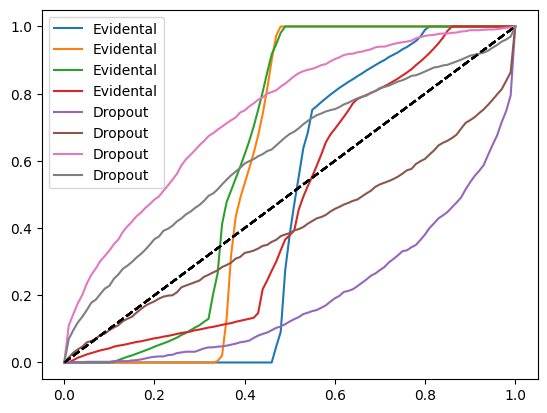

In [ ]:
plot_(evi['mu'], evi['sigma'],evi['test'], 'Evidental', 0)
plot_(evi['mu'], evi['sigma'],evi['test'], 'Evidental', 1)
plot_(evi['mu'], evi['sigma'],evi['test'], 'Evidental', 2)
plot_(evi['mu'], evi['sigma'],evi['test'], 'Evidental', 3)

#plot_(gaussian['mu'], gaussian['sigma'],gaussian['test'], 'Gaussian', 0)

plot_(drop['mu'], drop['sigma'],drop['test'], 'Dropout', 0)
plot_(drop['mu'], drop['sigma'],drop['test'], 'Dropout', 1)
plot_(drop['mu'], drop['sigma'],drop['test'], 'Dropout', 2)
plot_(drop['mu'], drop['sigma'],drop['test'], 'Dropout', 3)
'''
plot_(ense['mu'], ense['sigma'],ense['test'], 'Ensemble', 0)
plot_(ense['mu'], ense['sigma'],ense['test'], 'Ensemble', 1)
plot_(ense['mu'], ense['sigma'],ense['test'], 'Ensemble', 2)
plot_(ense['mu'], ense['sigma'],ense['test'], 'Ensemble', 3)
'''
plt.legend()